# Re-analysis of LatentFC by Ethan McCormick
(01/11/21)

In [1]:
# load relevant libraries
from __future__ import division
import sys,os
import numpy as np
import pandas as pd
import seaborn as sns
from rpy2.robjects.packages import importr
psych = importr('psych')
import rpy2.robjects.numpy2ri
rpy2.robjects.numpy2ri.activate()
import subprocess
import h5py
import nibabel as ni
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from scipy.sparse import csr_matrix
from scipy.stats import pearsonr, spearmanr, ttest_rel, sem, t, norm
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge
import seaborn as sns
sys.path.append('/projects/f_mc1689_1/LatentFC/docs/scripts/exploratory')
os.chdir('/projects/f_mc1689_1/LatentFC/docs/scripts')
from math import atanh, pow
from numpy import tanh

In [2]:
homedir = '/projects/f_mc1689_1/LatentFC/data/hcpPostProcCiric'
subj_group = 'exploratory'
data_group = 'loo'
control_tp = True

## Compute Latent and Average Connections and Average Matrices

In [3]:
# %%bash
# #subjs_group=(exploratory validation overall)
# #data_group=(overall loo)
# #control_tp=(0 1)
# subjs_group=(exploratory validation overall)
# data_group=(overall loo)
# control_tp=(0 1)

# for i in "${subjs_group[@]}"; do 
#     for j in "${data_group[@]}"; do
#         for k in "${control_tp[@]}"; do
#             echo ${i}_${j}_${k}
#             sbatch --job-name=compute_fc_${i}_${j}_${k} --nodes=1 --ntasks=1 --time=2-00:00:00 \
#             --partition=n_mc1689_1 --mail-type=END,FAIL --mail-user=ethan.mccormick@rutgers.edu \
#             --output=slurm.%j.compute_fc_${i}_${j}_${k}.out --mem=10g \
#             --wrap="python /projects/f_mc1689_1/LatentFC/docs/scripts/compute_fc.py ${i} ${j} ${k}"
#         done;
#     done;
# done

In [4]:
# %%bash
# subjs_group=(exploratory validation overall)
# data_group=(overall loo)
# control_tp=(0 1)

# for i in "${subjs_group[@]}"; do 
#     for j in "${data_group[@]}"; do
#         for k in "${control_tp[@]}"; do
#             echo ${i}_${j}_${k}
#             sbatch --job-name=create_connectivity_mats_${i}_${j}_${k} --nodes=1 --ntasks=1 --time=2-00:00:00 \
#             --partition=n_mc1689_1 --mail-type=END,FAIL --mail-user=ethan.mccormick@rutgers.edu \
#             --output=slurm.%j.create_connectivity_mats_${i}_${j}_${k}.out --mem=5g \
#             --wrap="python /projects/f_mc1689_1/LatentFC/docs/scripts/create_connectivity_mats.py ${i} ${j} ${k}"
#         done;
#     done;
# done

In [ ]:
%%bash
subjs_group=(exploratory validation overall)
data_group=(overall)
control_tp=(0 1)

for i in "${subjs_group[@]}"; do 
    for j in "${data_group[@]}"; do
        for k in "${control_tp[@]}"; do
            echo ${i}_${j}_${k}
            sbatch --job-name=create_connectivity_mats_${i}_${j}_${k} --nodes=1 --ntasks=1 --time=2-00:00:00 \
            --partition=n_mc1689_1 --mail-type=END,FAIL --mail-user=ethan.mccormick@rutgers.edu \
            --output=slurm.%j.create_connectivity_mats_${i}_${j}_${k}.out --mem=5g \
            --wrap="python /projects/f_mc1689_1/LatentFC/docs/scripts/create_connectivity_mats.py ${i} ${j} ${k}"
        done;
    done;
done

## Setup and Read in Data 

In [3]:
# Set up parameters
subjsf = '%s/%s_subjects.npy' % (homedir, subj_group)
subjs = np.load(subjsf)
subjs = np.array(subjs, dtype=int).tolist()

all_states = np.load('%s/states.npy' % (homedir)).tolist()
all_states = [x.decode('utf-8') for x in all_states]
n_rois = 360
n_connections = 64620
n_subjs = len(subjs)
n_states = len(all_states)
n_conds = 24

networkdef = np.loadtxt('/projects/f_mc1689_1/LatentFC/data/hcpPostProcCiric/network_partition.txt')
networkorder = np.asarray(sorted(range(len(networkdef)), key=lambda k: networkdef[k]))

tasks = {'EMOTION':[0,1],
         'GAMBLING':[2,3],
         'LANGUAGE':[4,5],
         'MOTOR':[6,7,8,9,10,11],
         'RELATIONAL':[12,13],
         'SOCIAL':[14,15],
         'WM':[16,17,18,19,20,21,22,23]}

taskNames = ['EMOTION', 'GAMBLING', 'LANGUAGE', 'MOTOR', 'RELATIONAL', 'SOCIAL', 'WM']

TRsPerRun = [176,176,253,253,316,316,284,284,232,232,274,274,405,405]

restRuns = ['rfMRI_REST1_RL', 'rfMRI_REST1_LR','rfMRI_REST2_RL', 'rfMRI_REST2_LR']

taskRuns= ['tfMRI_EMOTION_RL','tfMRI_EMOTION_LR','tfMRI_GAMBLING_RL','tfMRI_GAMBLING_LR',
           'tfMRI_LANGUAGE_RL','tfMRI_LANGUAGE_LR','tfMRI_MOTOR_RL','tfMRI_MOTOR_LR',
           'tfMRI_RELATIONAL_RL','tfMRI_RELATIONAL_LR','tfMRI_SOCIAL_RL','tfMRI_SOCIAL_LR',
           'tfMRI_WM_RL','tfMRI_WM_LR']

latent_task_dict = {'EMOTION':1, 'GAMBLING':2, 'MOTOR':3, 'RELATIONAL':4, 'SOCIAL':5, 'WM':6, 
                    'LANGUAGE_MATH':7, 'LANGUAGE_STORY':8}

titles = np.array(['Rest', 'Emotion', 'Gambling', 'Motor', 'Relational', 'Social', 'Working Memory', \
                   'Language (Math)', 'Language (Story)'])

condscan = np.array(['Emotion', 'Gambling', 'Language', 'Motor', 'Relational', 'Social', 'Working Memory'])

condname = np.array(['Fear', 'Neut', 'Win', 'Loss', 'Story', 'Math', 'Cue', 'L Finger', 'R Finger', 'L Hand', 'R Hand', \
                    'Target', 'Relation', 'Match', 'Mental', 'Random', 'Body', 'Faces', 'Places', 'Tools', 'Body', \
                    'Faces', 'Places', 'Tools'])

task_df_f = '%s/hcp_task_condition_labels.csv' % (homedir)
task_df = pd.read_csv(task_df_f, index_col=0)
conds = task_df.Full

partition_labels = pd.read_csv('%s/network_partition_labels.csv' % (homedir), index_col=0)
partition = np.loadtxt('%s/reorder_network_partition.txt' % (homedir))
partition_mat = np.zeros(shape=(360,360))
for i in np.arange(360):
    for j in np.arange(360):
        if i < j:
            if partition[i] == partition[j]:
                partition_mat[i,j] = partition[i]
        if i >=j:
            partition_mat[i,j] = -1
in_partition_mat = partition_mat > 0
out_partition_mat = partition_mat == 0
partition_mat_full = partition_mat + partition_mat.T

In [4]:
# Set up Functions + Directories
def setup_directories(homedir, subj_group, data_group, control_tp, task_only=False):
    adjmatdir = '%s/Results/adjmat/correlation' % (homedir)
    datadir = '%s/Results/fa/correlation/%s/%s' % (homedir, subj_group, data_group)
    figdir = '/projects/f_mc1689_1/LatentFC/docs/figures/' #% (subj_group, data_group)
    if control_tp:
        adjmatdir = '%s/control_tp' % (adjmatdir)
        datadir = '%s/control_tp' % (datadir)
        #figdir = '%s/control_tp' % (figdir)
    if task_only:    
        datadir = '%s/task_only' % (datadir)
        #figdir = '%s/task_only' % (figdir)
    #if not os.path.isdir(figdir):
        #os.mkdir(figdir)
    return adjmatdir, datadir, figdir

adjmatdir, datadir, figdir = setup_directories(homedir, subj_group, data_group, control_tp)

def activityFlowXtoY(activity, connectivity):
    """
    Activity flow mapping between component (e.g., region or network) X to component Y
    
    Parameters:
        activity - a sample (e.g., miniblocks) X feature (e.g., regions/vertices) matrix
        connectivity - a functional connectivity matrix from X to Y; rows must have same number of columns as in activity
    Returns: 
        Predictions for component Y in terms of samples X features 
    
    # Takuya Ito (takuya.ito@rutgers.edu)
    # Citation: Ito T, Kulkarni KR, Schultz DH, Mill RD, Chen RH, Solomyak LI, Cole MW (2017). \
    Cognitive task information is transferred between brain regions via resting-state network topology. \
    bioRxiv. https://doi.org/10.1101/101782
    """
    predictions = np.dot(activity, connectivity)
    return predictions

def loadTaskActivity(subj, task, model='24pXaCompCorXVolterra', zscore=True):
    datafile = '%s/%s_glmOutput_data.h5' % (homedir, subj)
    h5f = h5py.File(datafile,'r')
    dataid = 'tfMRI_' + task + '_' + model + '_taskReg_betas_canonical'
    tmp = h5f['taskRegression'][dataid][:]
    betas = tmp[:,1:].T
    betas = np.asarray(betas).T
    h5f.close()
    return betas

def get_subject_full_rest_adjmat(subj, adjmatdir=adjmatdir, control_tp=False, fshr_xfm=True):
    if control_tp:
        f = '%s/rest_2112/%s_adjmat.npy' % (adjmatdir, subj)
    else:
        f = '%s/rest/%s_adjmat.npy' % (adjmatdir, subj)
    mat = np.load(f)
    if fshr_xfm:
        return np.arctanh(mat)
    else:
        return mat

def get_subject_state_latent_mat(subj, state, datadir=datadir):
    latent_dir = '%s/latent_fc/%s' % (datadir, state)
    matf = '%s/%s_latent_connectivity_mat2.npy' % (latent_dir, subj)
    return np.load(matf)

def get_subject_latent_mat(subj, datadir=datadir):
    latent_dir = '%s/latent_fc' % (datadir)
    matf = '%s/%s_latent_connectivity_mat2.npy' % (latent_dir, subj)
    return np.load(matf)

def get_state_latent_mats(state, subjs, datadir=datadir):
    subs = np.array(subjs, dtype=str)
    state_latent_df = pd.DataFrame(index=subjs, columns=range(64620))
    for subj in subjs:
        subj_mat = get_subject_state_latent_mat(subj, state)
        state_latent_df.loc[subj] = subj_mat[np.triu_indices(360,1)]
    return state_latent_df

def get_state_average_latent_mat(state, subjs, datadir=datadir):
    state_latent_df = get_state_latent_mats(state, subjs, datadir)
    return state_latent_df.mean(axis=1)

def get_subject_state_average_mat(subj, state, datadir=datadir):
    avg_dir = '%s/latent_fc/%s' % (datadir, state)
    matf = '%s/%s_avg_connectivity_mat.npy' % (avg_dir, subj)
    return np.load(matf)

def get_subject_average_mat(subj, datadir=datadir):
    avg_dir = '%s/latent_fc' % (datadir)
    matf = '%s/%s_avg_connectivity_mat.npy' % (avg_dir, subj)
    return np.load(matf)

def get_subject_score_mat(subj, datadir=datadir):
    avg_dir = '%s/latent_fc' % (datadir)
    matf = '%s/%s_score_connectivity_mat.npy' % (avg_dir, subj)
    return np.load(matf)

def get_subject_state_score_mat(subj, state, datadir):
    avg_dir = '%s/latent_fc/%s' % (datadir, state)
    matf = '%s/%s_score_connectivity_mat.npy' % (avg_dir, subj)
    return np.load(matf)

def get_subject_state_adjmat(subj, state, data, subjs,
                             homedir=homedir, 
                             fshr_xfm=True):
    subj_idx = subjs.index(subj)
    all_states_f = '%s/states.npy' % (homedir)
    all_states = list(np.load(all_states_f))
    all_states = [x.decode('utf-8') for x in all_states]
    state_idx = all_states.index(state)
    subj_dat = dat[subj_idx, state_idx, :]
    mat = np.zeros(shape=(360,360))
    mat[np.triu_indices(360,1)] = subj_dat
    mat += mat.T
    if fshr_xfm == False:
        return mat
    else:
        return np.arctanh(mat)

def get_subject_fshr_average_adjmat(subj, states, data, subjs, fshr_xfm=True):
    _, n_connections = np.array(np.triu_indices(360,1)).shape
    dat = np.zeros(shape=(len(states), n_connections))
    for i, state in enumerate(states):
        state_mat = get_subject_state_adjmat(subj, state, data, subjs)
        state_dat = state_mat[np.triu_indices(360,1)]
        dat[i,:] = state_dat
    avg_mat = np.zeros(shape=(360,360))
    avg_mat[np.triu_indices(360,1)] = dat.mean(axis=0)
    return avg_mat

def convert_to_matrix(data,n_rois=n_rois):
    mat = np.zeros(shape=(n_rois, n_rois))
    mat[np.triu_indices(n_rois, 1)] = data
    mat = mat + mat.T
    return mat

def calc_module_stats(dat, p=partition, plabels=partition_labels):
    for i in np.arange(1,13):
        outstr = '%s: %.2f' % (plabels.Network[i], np.nanmean(dat[p == i]))
        print(outstr)

glasserfile2 = '/projects/f_mc1689_1/AnalysisTools/ActflowToolbox/tools/Q1-Q6_RelatedParcellation210.LR.CorticalAreas_dil_Colors.32k_fs_RL.dlabel.nii'
def map_to_surface(mat,filename,glasserfile2=glasserfile2,nParcels=360):
    """
    Maps a region X column 2d matrix into a dscalar file with 64k vertices
    Uses the Glasser et al. 2016 ROI parcellation
    
    Input Parameters:
        mat     :   region x column (features/activations, etc.) 2D MATRIX to be mapped onto the surface. MUST BE A 2D MATRIX.
                    mat can either be 360 mat or ~59k mat. If 360, will automatically map back to ~59k
        filename:   a string indicating the directory + filename of the output. Do not include a suffix (e.g., ".dscalar.nii" to the file. Suffixes will be added automatically.
    """
    #### Map back to surface
    glasser2 = ni.load(glasserfile2).get_data()
    glasser2 = np.squeeze(glasser2)
    if mat.shape[0]==nParcels:
        out_mat = np.zeros((glasser2.shape[0],mat.shape[1]))
        for roi in np.arange(nParcels):
            vertex_ind = np.where(glasser2==roi+1)[0]
            for col in range(mat.shape[1]):
                out_mat[vertex_ind,col] = mat[roi,col]
    else:
        out_mat = mat

    #### 
    # Write file to csv and run wb_command
    np.savetxt(filename + '.csv', out_mat,fmt='%s')
    wb_file = filename + '.dscalar.nii'
    wb_command = 'wb_command -cifti-convert -from-text ' + filename + '.csv ' + glasserfile2 + ' ' + wb_file + ' -reset-scalars'
    os.system(wb_command)
    os.remove(filename + '.csv')
    print("CIFTI dscalar is output as:" + wb_file)

import matplotlib.colors as colors
class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))
    
print(adjmatdir)
print(datadir)
print(figdir)

/projects/f_mc1689_1/LatentFC/data/hcpPostProcCiric/Results/adjmat/correlation/control_tp
/projects/f_mc1689_1/LatentFC/data/hcpPostProcCiric/Results/fa/correlation/exploratory/loo/control_tp
/projects/f_mc1689_1/LatentFC/docs/figures/


In [5]:
def plot_significant_difference(data1, data2, r1, r2, barWidth=0.25, adjust_y=1, adjust_x2=0, \
                                fontsize=16, alpha=0.05, fischer=True, bonferroni=True):
    x_dim, y_dim = data1.shape
    adjust_x = np.nanmean(np.column_stack((r1, r2)), axis=1) - (barWidth / 2)
    if bonferroni:
        alpha = alpha/y_dim
    for i in np.arange(y_dim):
        temp = np.column_stack((data1[:,i], data2[:,i]))
        temp = temp[~np.isnan(temp).any(axis=1),:]
        temp1 = temp[:,0]; temp2 = temp[:,1]
        if fischer:
            t_stat, p_val = ttest_rel(np.arctanh(temp1), np.arctanh(temp2))
        else:
            t_stat, p_val = ttest_rel(temp1, temp2)
        if p_val <= alpha:
            data_means = [np.nanmean(data1[:,i]), np.nanmean(data2[:,i])]
            data_stds = [np.nanstd(data1[:,i]), np.nanstd(data2[:,i])]
            max_y = np.max(data_means)
            ind = data_means.index(max_y)
            plt.text(adjust_x[i] + adjust_x2, max_y + (adjust_y*0.05*max_y), '*', fontsize=fontsize)

## Calculate Loading Information

In [10]:
control_tp_loadings = True
if control_tp_loadings:
    loadingfile = '%s/Results/fa/correlation/%s/overall/control_tp/factor_loadings_minres_tenBerge.csv' % (homedir, subj_group)
else:
    loadingfile = '%s/Results/fa/correlation/%s/overall/factor_loadings_minres_tenBerge.csv' % (homedir, subj_group)
load_df = pd.read_csv(loadingfile, index_col=0)
load_df.shape

(64620, 9)

### Average Loading per Scan

In [11]:
np.mean(load_df, axis=0)

rest              0.340890
emotion           0.379848
gambling          0.432287
motor             0.407406
relational        0.432258
social            0.416761
wm                0.442549
language_math     0.517610
language_story    0.536733
dtype: float64

### Percent of Connections with Significant Loadings per Scan

In [12]:
np.sum(load_df >= .4, axis=0) / len(load_df)

rest              0.316125
emotion           0.462659
gambling          0.621897
motor             0.548452
relational        0.622532
social            0.583720
wm                0.648932
language_math     0.823708
language_story    0.863247
dtype: float64

In [13]:
np.sum(load_df >= 0.0, axis=0) / len(load_df)

rest              0.989725
emotion           0.986877
gambling          0.990792
motor             0.994011
relational        0.990607
social            0.993377
wm                0.992448
language_math     0.996193
language_story    0.996503
dtype: float64

### Percent of All Connections with Significant Loadings

In [ ]:
np.mean(np.sum(load_df >= .4, axis=0) / len(load_df))

### Percent of Connections with 2 or more Significant Loadings

In [ ]:
np.sum(np.sum(load_df >= .4, axis=1) >= 2) / len(load_df)

## Visualize Connectivity Matrices

In [20]:
control_tp_loadings = True

datf = '%s/%s_data_summary_subj_by_state_by_connectivity.npy' % (adjmatdir, subj_group)
dat = np.load(datf)
dat.shape

(176, 9, 64620)

In [21]:
if control_tp_loadings:
    tmpdatdir = '%s/Results/fa/correlation/%s/overall/control_tp' % (homedir, subj_group)
else:
    tmpdatdir = '%s/Results/fa/correlation/%s/overall' % (homedir, subj_group)

latent_dat = pd.DataFrame(index=subjs, columns=np.arange(n_connections))
for subj in subjs:
    latent_mat = get_subject_latent_mat(subj, datadir=tmpdatdir)
    latent_dat.loc[subj] = latent_mat[np.triu_indices(n_rois,1)]
latent_dat.shape

(176, 64620)

saving adjmat for rest
saving adjmat for emotion
saving adjmat for gambling
saving adjmat for motor
saving adjmat for relational
saving adjmat for social
saving adjmat for wm
saving adjmat for language_math
saving adjmat for language_story


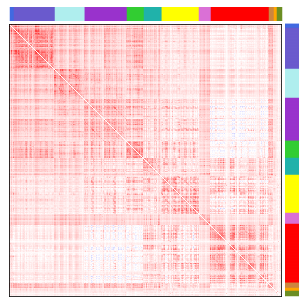

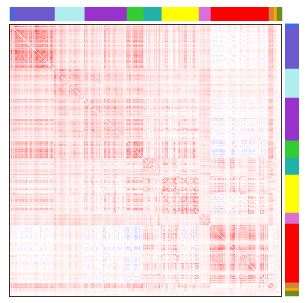

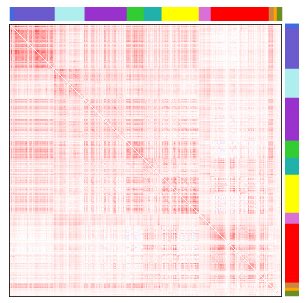

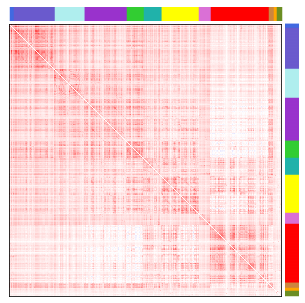

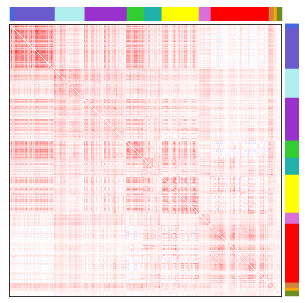

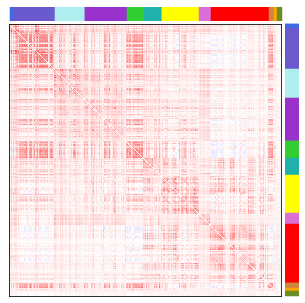

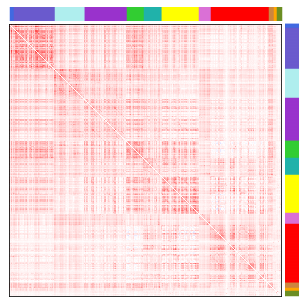

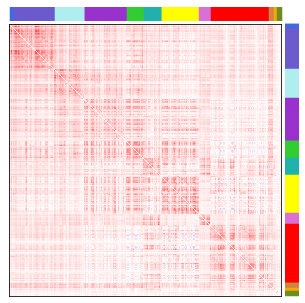

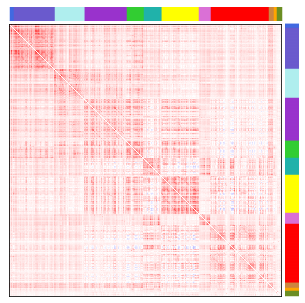

In [22]:
for i in np.arange(dat.shape[1]):
    tmp_mat = convert_to_matrix(np.mean(dat, axis=0)[i,:])

    fig = plt.figure(figsize=(6,5))
    ax = fig.add_subplot(111)
    ax.yaxis.set_ticks_position('right')
    ax.xaxis.set_ticks_position('top')
    ax.tick_params(axis=u'y', which=u'both',length=0)
    im = ax.imshow(tmp_mat, cmap='bwr', clim=(-1,1))
    ax.tick_params(axis=u'both', which=u'both',length=0)

    plt.xticks(np.arange(0,360), ['|']*360);
    for xtick, t in zip(ax.get_xticklabels(), partition):
        xtick.set_color(partition_labels.Palette.loc[t])
        xtick.set_weight('bold')
    plt.xticks(fontsize=14);

    plt.yticks(np.arange(0,360), ['|']*360, rotation=90);
    for ytick, t in zip(ax.get_yticklabels(), partition):
        ytick.set_color(partition_labels.Palette.loc[t])
        ytick.set_weight('bold')
    plt.yticks(fontsize=14);

    if control_tp_loadings:
        plotname = '%s/stateadjmat_%s_%s_controltp' % (figdir, all_states[i], subj_group)
    else:
        plotname = '%s/stateadjmat_%s_%s_alltp' % (figdir, all_states[i], subj_group)   

    plt.savefig('%s.pdf' % plotname)
    plt.savefig('%s.png' % plotname, dpi=300, transparent=True)
    print('saving adjmat for %s' % all_states[i])

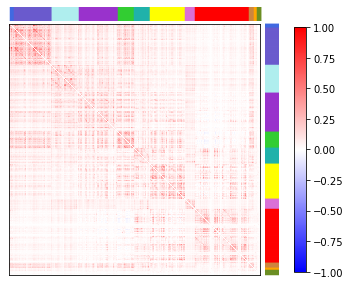

In [40]:
tmp_mat = convert_to_matrix(np.mean(latent_dat, axis=0))

fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot(111)
ax.yaxis.set_ticks_position('right')
ax.xaxis.set_ticks_position('top')
ax.tick_params(axis=u'y', which=u'both',length=0)
im = ax.imshow(tmp_mat, cmap='bwr', clim=(-1,1))
ax.tick_params(axis=u'both', which=u'both',length=0)

plt.xticks(np.arange(0,360), ['|']*360);
for xtick, t in zip(ax.get_xticklabels(), partition):
    xtick.set_color(partition_labels.Palette.loc[t])
    xtick.set_weight('bold')
plt.xticks(fontsize=14);

plt.yticks(np.arange(0,360), ['|']*360, rotation=90);
for ytick, t in zip(ax.get_yticklabels(), partition):
    ytick.set_color(partition_labels.Palette.loc[t])
    ytick.set_weight('bold')
plt.yticks(fontsize=14);

fig.colorbar(im, orientation='vertical', pad=0.1, shrink=.90)

if control_tp_loadings:
    plotname = '%s/latentmat_%s_controltp' % (figdir, subj_group)
else:
    plotname = '%s/latentmat_%s_alltp' % (figdir, subj_group)   

plt.savefig('%s.pdf' % plotname)
plt.savefig('%s.png' % plotname, dpi=600, transparent=True)

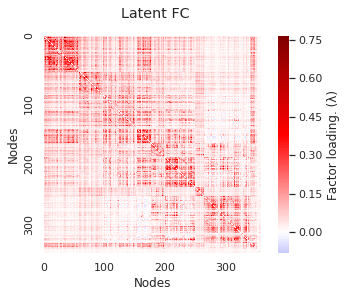

In [47]:
if control_tp_loadings:
    plotname = '%s/latentmat_%s_controltp' % (figdir, subj_group)
else:
    plotname = '%s/latentmat_%s_alltp' % (figdir, subj_group)   

ax = sns.heatmap(convert_to_matrix(np.mean(latent_dat, axis=0)),square=True,center=0,cmap='seismic',cbar=True,xticklabels=100,yticklabels=100, cbar_kws={'label': 'Factor loading. (λ)'})
ax.figure.suptitle('Latent FC')
ax.set(xlabel='Nodes',ylabel='Nodes')
fig=ax.get_figure()
fig.savefig('%s.pdf' % plotname)

In [46]:
import matplotlib as mpl
font_paths = mpl.font_manager.findSystemFonts()
font_objects = mpl.font_manager.createFontList(font_paths)
font_names = [f.name for f in font_objects]
print(font_names)

['Nimbus Roman', 'Nimbus Sans Narrow', 'URW Bookman', 'C059', 'Liberation Sans', 'URW Bookman', 'Nimbus Sans', 'Nimbus Mono PS', 'D050000L', 'DejaVu Sans', 'C059', 'Liberation Sans', 'DejaVu Sans', 'URW Bookman', 'Nimbus Sans Narrow', 'URW Gothic', 'DejaVu Sans', 'Liberation Sans', 'C059', 'Nimbus Sans', 'URW Gothic', 'P052', 'DejaVu Sans', 'Liberation Sans', 'DejaVu Sans', 'Nimbus Roman', 'Nimbus Roman', 'DejaVu Sans', 'Nimbus Sans Narrow', 'C059', 'URW Gothic', 'Nimbus Sans Narrow', 'DejaVu Sans', 'Nimbus Sans', 'URW Bookman', 'P052', 'DejaVu Sans', 'Nimbus Mono PS', 'Nimbus Mono PS', 'P052', 'DejaVu Sans', 'P052', 'Nimbus Mono PS', 'URW Gothic', 'Nimbus Sans', 'Z003', 'Nimbus Roman']


## Generalizing Connectivity

In [48]:
datf = '%s/%s_data_summary_subj_by_state_by_connectivity.npy' % (adjmatdir, subj_group)
dat = np.load(datf)

In [49]:
r_state_rest_df = pd.DataFrame(index=subjs, columns=all_states)
for subj in subjs:
    subj_rest_mat = get_subject_full_rest_adjmat(subj, control_tp=control_tp)
    subj_rest_dat = subj_rest_mat[np.triu_indices(360,1)]
    for state in all_states:
        subj_state_mat = get_subject_state_adjmat(subj, state, dat, subjs)
        subj_state_dat = subj_state_mat[np.triu_indices(360,1)]
        r_state_rest_df[state].loc[subj] = (pearsonr(subj_state_dat, subj_rest_dat)[0])
        
np.mean(r_state_rest_df, axis=0)

/projects/f_mc1689_1/AnalysisTools/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: divide by zero encountered in arctanh


rest              0.725244
emotion           0.593415
gambling          0.566168
motor             0.613193
relational        0.557342
social            0.586083
wm                0.581813
language_math     0.564935
language_story    0.579572
dtype: float64

In [50]:
r_state_average_df = pd.DataFrame(index=subjs, columns=all_states)
for subj in subjs:
    for state in all_states:
        if data_group == 'overall':
            subj_average_mat = get_subject_average_mat(subj)
        elif data_group == 'loo':
            subj_average_mat = get_subject_state_average_mat(subj, state)
        subj_average_dat = subj_average_mat[np.triu_indices(360,1)]
        subj_state_mat = get_subject_state_adjmat(subj, state, dat, subjs)
        subj_state_dat = subj_state_mat[np.triu_indices(360,1)]
        nonan_idx = ~np.isnan(np.column_stack((subj_state_dat,subj_average_dat))).any(axis=1)
        r_state_average_df[state].loc[subj] = (pearsonr(subj_state_dat[nonan_idx], subj_average_dat[nonan_idx])[0])

np.mean(r_state_average_df, axis=0)

rest              0.655260
emotion           0.674062
gambling          0.686540
motor             0.679402
relational        0.683153
social            0.650080
wm                0.707983
language_math     0.667247
language_story    0.660400
dtype: float64

In [51]:
r_state_latent_df = pd.DataFrame(index=subjs, columns=all_states)
for subj in subjs:
    for state in all_states:
        if data_group == 'overall':
            subj_latent_mat = get_subject_latent_mat(subj)
        elif data_group == 'loo':
            subj_latent_mat = get_subject_state_latent_mat(subj, state)
        subj_latent_dat = subj_latent_mat[np.triu_indices(360,1)]
        subj_state_mat = get_subject_state_adjmat(subj, state, dat, subjs)
        subj_state_dat = subj_state_mat[np.triu_indices(360,1)]
        nonan_idx = ~np.isnan(np.column_stack((subj_state_dat,subj_latent_dat))).any(axis=1)
        r_state_latent_df[state].loc[subj] = (pearsonr(subj_state_dat[nonan_idx], subj_latent_dat[nonan_idx])[0])
            
np.mean(r_state_latent_df, axis=0)

rest              0.652602
emotion           0.665277
gambling          0.681961
motor             0.674559
relational        0.677145
social            0.656670
wm                0.710135
language_math     0.667884
language_story    0.660992
dtype: float64

/projects/f_mc1689_1/AnalysisTools/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


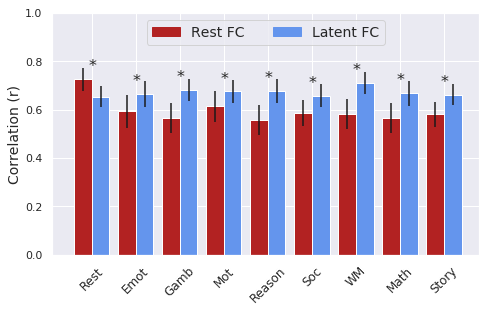

In [52]:
plt.figure(figsize=(7,4.5));
plt.ylim(0, 1.)
plt.xlim(-0.7, 9)
state_labs = ['Rest','Emot','Gamb','Mot','Reason','Soc','WM','Math','Story']

barWidth = 0.4
r1 = np.arange(len(all_states))
r2 = [x + barWidth for x in r1]
r3 = [x + (barWidth/2) for x in r1]

plt.bar(r1, np.nanmean(r_state_rest_df, axis=0),   color='firebrick',      width=barWidth, yerr=sem(r_state_rest_df.to_numpy(dtype=float),   axis=0, nan_policy='omit'), ecolor='k');
plt.bar(r2, np.nanmean(r_state_latent_df, axis=0), color='cornflowerblue', width=barWidth, yerr=sem(r_state_latent_df.to_numpy(dtype=float), axis=0, nan_policy='omit'), ecolor='k');

plt.xticks(r3, state_labs, rotation=45, fontsize=12);
plt.ylabel('Correlation (r)', fontsize=14);
plot_significant_difference(r_state_rest_df.to_numpy(dtype=float), r_state_latent_df.to_numpy(dtype=float), barWidth=barWidth, r1=r1, r2=r2, adjust_x2=.125);
red_patch = mpatches.Patch(color='firebrick', label='Rest FC')
blue_patch = mpatches.Patch(color='cornflowerblue', label='Latent FC')
plt.legend(handles=[red_patch, blue_patch], loc='upper center', fontsize=14, ncol=2)
plt.tight_layout()

if control_tp:
    plotname = '%s/generalizingconnectivity_restlatent_%s_%s_controltp' % (figdir, subj_group, data_group)
else:
    plotname = '%s/generalizingconnectivity_restlatent_%s_%s_alltp' % (figdir, subj_group, data_group)
plt.savefig('%s.pdf' % plotname)
plt.savefig('%s.png' % plotname, dpi=300, transparent=True)

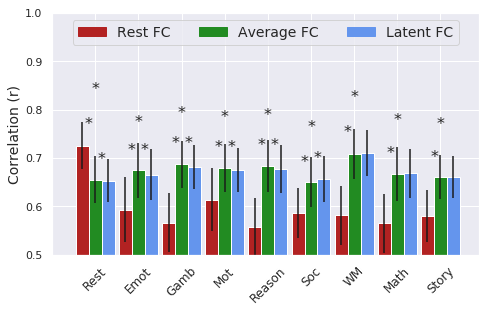

In [56]:
plt.figure(figsize=(7,4.5));
plt.ylim(0, 1.)
plt.xlim(-0.7, 9.2);
state_labs = ['Rest','Emot','Gamb','Mot','Reason','Soc','WM','Math','Story']

barWidth = 0.3
r1 = np.arange(len(all_states))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]

plt.bar(r1, np.nanmean(r_state_rest_df, axis=0),    color='firebrick',      width=barWidth, yerr=sem(r_state_rest_df.to_numpy(dtype=float),    axis=0, nan_policy='omit'), ecolor='k');
plt.bar(r2, np.nanmean(r_state_average_df, axis=0), color='forestgreen',    width=barWidth, yerr=sem(r_state_average_df.to_numpy(dtype=float), axis=0, nan_policy='omit'), ecolor='k');
plt.bar(r3, np.nanmean(r_state_latent_df, axis=0),  color='cornflowerblue', width=barWidth, yerr=sem(r_state_latent_df.to_numpy(dtype=float),  axis=0, nan_policy='omit'), ecolor='k');

plt.xticks(r2, state_labs, rotation=45, fontsize=12);
plt.ylabel('Correlation (r)', fontsize=14);

plot_significant_difference(r_state_rest_df.to_numpy(dtype=float), r_state_average_df.to_numpy(dtype=float), barWidth=barWidth, r1=r1, r2=r2, adjust_x2=.06125);
plot_significant_difference(r_state_average_df.to_numpy(dtype=float), r_state_latent_df.to_numpy(dtype=float), barWidth=barWidth, r1=r2, r2=r3, adjust_x2=.06125);
plot_significant_difference(r_state_rest_df.to_numpy(dtype=float), r_state_latent_df.to_numpy(dtype=float), barWidth=barWidth, r1=r1, r2=r3, adjust_x2=.06125, adjust_y=3);

red_patch = mpatches.Patch(color='firebrick', label='Rest FC')
green_patch = mpatches.Patch(color='forestgreen', label='Average FC')
blue_patch = mpatches.Patch(color='cornflowerblue', label='Latent FC')
plt.legend(handles=[red_patch, green_patch, blue_patch], loc='upper center', fontsize=14, ncol=3)
plt.tight_layout()

if control_tp:
    plotname = '%s/generalizingconnectivity_restaveragelatent_%s_%s_controltp' % (figdir, subj_group, data_group)
else:
    plotname = '%s/generalizingconnectivity_restaveragelatent_%s_%s_alltp' % (figdir, subj_group, data_group)
plt.savefig('%s.pdf' % plotname)
plt.savefig('%s.png' % plotname, dpi=300, transparent=True)

## ActFlow Analyses

### Read in Data

In [8]:
rest_dat = np.zeros(shape=(n_subjs, n_connections))
for i, subj in enumerate(subjs):
    mat = get_subject_full_rest_adjmat(subj, adjmatdir, control_tp=control_tp)
    dat = mat[np.triu_indices(n_rois,1)]
    rest_dat[i,:] = dat
rest_dat.shape

/projects/f_mc1689_1/AnalysisTools/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: divide by zero encountered in arctanh


(176, 64620)

In [9]:
if data_group == 'overall':
    latent_dat = np.zeros(shape=(n_subjs, n_connections))
    for i, subj in enumerate(subjs):
        tmp_latent_mat = get_subject_latent_mat(subj, datadir)
        tmp_latent_dat = tmp_latent_mat[np.triu_indices(n_rois,1)]
        latent_dat[i,:] = tmp_latent_dat
elif data_group == 'loo':        
    latent_dat = np.zeros(shape=(n_subjs, n_states, n_connections))
    for i, subj in enumerate(subjs):
        for j, state in enumerate(all_states):
            tmp_latent_mat = get_subject_state_latent_mat(subj, state, datadir)
            tmp_latent_dat = tmp_latent_mat[np.triu_indices(n_rois,1)]
            latent_dat[i,j,:] = tmp_latent_dat
latent_dat.shape

(176, 9, 64620)

In [10]:
if data_group == 'overall':
    average_dat = np.zeros(shape=(n_subjs, n_connections))
    for i, subj in enumerate(subjs):
        mat = get_subject_average_mat(subj, datadir)
        dat = mat[np.triu_indices(n_rois,1)]
        average_dat[i,:] = dat
elif data_group == 'loo':
    average_dat = np.zeros(shape=(n_subjs, n_states, n_connections))
    for i, subj in enumerate(subjs):
        for j, state in enumerate(all_states):
            mat = get_subject_state_average_mat(subj, state, datadir)
            dat = mat[np.triu_indices(n_rois,1)]
            average_dat[i,j,:] = dat
average_dat.shape

(176, 9, 64620)

In [11]:
beta_dat = np.zeros(shape=(n_subjs, n_conds, n_rois))
for i, subj in enumerate(subjs):
    for task in taskNames:
        tmp_betas = loadTaskActivity(str(subj), task, model='24pXaCompCorXVolterra', zscore=True)
        beta_dat[i,tasks[task],:] = tmp_betas.T
beta_dat = beta_dat[:,:,networkorder]
beta_dat.shape

(176, 24, 360)

### Generate ActFlow Predictions

In [12]:
all_cond_predicted_betas_rest = np.zeros(shape=(n_subjs, n_conds, n_rois))
all_cond_predicted_betas_average = np.zeros(shape=(n_subjs, n_conds, n_rois))
all_cond_predicted_betas_latent = np.zeros(shape=(n_subjs, n_conds, n_rois))
for i, subj in enumerate(subjs):
    rest_mat = convert_to_matrix(rest_dat[i,:])
    for task in tasks.keys():
        for j in tasks[task]:
            # load activation (i.e. beta) values
            cond_betas = beta_dat[i,j,:]
                
            # actflow based on rest
            rest_prediction = activityFlowXtoY(cond_betas, rest_mat)
            all_cond_predicted_betas_rest[i,j,:] = rest_prediction
            
            # actflow based on latent fc
            if task == 'LANGUAGE' and j == 4:
                task_ind = 8
            elif task == 'LANGUAGE' and j == 5:
                task_ind = 7
            else:
                task_ind = latent_task_dict[task]
                
            if data_group == 'overall':
                latent_mat = convert_to_matrix(latent_dat[i,:])
                average_mat = convert_to_matrix(average_dat[i,:])
            elif data_group == 'loo':
                latent_mat = convert_to_matrix(latent_dat[i,task_ind,:])
                average_mat = convert_to_matrix(average_dat[i,task_ind,:])
            
            # actflow based on latent fc
            latent_prediction = activityFlowXtoY(cond_betas, latent_mat)
            all_cond_predicted_betas_latent[i,j,:] = latent_prediction
            
            # actflow based on average
            average_prediction = activityFlowXtoY(cond_betas, average_mat)
            all_cond_predicted_betas_average[i,j,:] = average_prediction
                        
all_cond_predicted_betas_average.shape

(176, 24, 360)

#### Plot Actual Betas and ActFlow Predictions

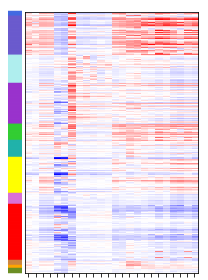

In [264]:
fig = plt.figure(figsize=(3,4))
ax = fig.add_subplot(111)
ax.tick_params(axis=u'y', which=u'both',length=0)
im = ax.imshow(np.matrix(beta_dat.mean(axis=0)).T, aspect='auto', \
               cmap='bwr', norm=MidpointNormalize(midpoint=0), \
              interpolation='nearest')
plt.xticks(np.arange(24), ['']*24)
plt.yticks(np.arange(0,360), ['|']*360, rotation=90)
for ytick, i in zip(ax.get_yticklabels(), partition):
    ytick.set_color(partition_labels.Palette.loc[i])
    ytick.set_weight('bold')
plt.yticks(fontsize=14)
plt.tight_layout()

if control_tp:
    plotname = '%s/averageactivation_actual' % (figdir)
else:
    plotname = '%s/averageactivation_actual' % (figdir)
plt.savefig('%s.pdf' % plotname)
plt.savefig('%s.png' % plotname, dpi=300, transparent=True)

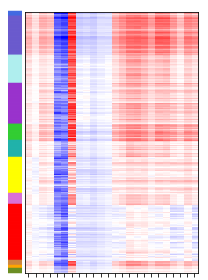

In [265]:
fig = plt.figure(figsize=(3,4))
ax = fig.add_subplot(111)
ax.tick_params(axis=u'y', which=u'both',length=0)
im = ax.imshow(np.matrix(all_cond_predicted_betas_rest.mean(axis=0)).T, aspect='auto', \
               cmap='bwr', norm=MidpointNormalize(midpoint=0), \
              interpolation='nearest')
plt.xticks(np.arange(24), ['']*24)
plt.yticks(np.arange(0,360), ['|']*360, rotation=90)
for ytick, i in zip(ax.get_yticklabels(), partition):
    ytick.set_color(partition_labels.Palette.loc[i])
    ytick.set_weight('bold')
plt.yticks(fontsize=14)
plt.tight_layout()

if control_tp:
    plotname = '%s/averageactivation_restpred_%s_%s_controltp' % (figdir, subj_group, data_group)
else:
    plotname = '%s/averageactivation_restpred_%s_%s_alltp' % (figdir, subj_group, data_group)
plt.savefig('%s.pdf' % plotname)
plt.savefig('%s.png' % plotname, dpi=300, transparent=True)

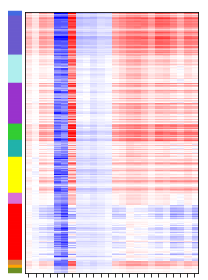

In [266]:
fig = plt.figure(figsize=(3,4))
ax = fig.add_subplot(111)
ax.tick_params(axis=u'y', which=u'both',length=0)
im = ax.imshow(np.matrix(all_cond_predicted_betas_average.mean(axis=0)).T, aspect='auto', \
               cmap='bwr', norm=MidpointNormalize(midpoint=0), \
              interpolation='nearest')
plt.xticks(np.arange(24), ['']*24)
plt.yticks(np.arange(0,360), ['|']*360, rotation=90)
for ytick, i in zip(ax.get_yticklabels(), partition):
    ytick.set_color(partition_labels.Palette.loc[i])
    ytick.set_weight('bold')
plt.yticks(fontsize=14)
plt.tight_layout()

if control_tp:
    plotname = '%s/averageactivation_averagepred_%s_%s_controltp' % (figdir, subj_group, data_group)
else:
    plotname = '%s/averageactivation_averagepred_%s_%s_alltp' % (figdir, subj_group, data_group)
plt.savefig('%s.pdf' % plotname)
plt.savefig('%s.png' % plotname, dpi=300, transparent=True)

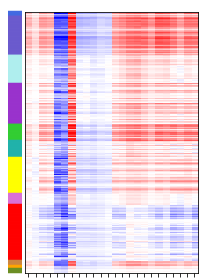

In [267]:
fig = plt.figure(figsize=(3,4))
ax = fig.add_subplot(111)
ax.tick_params(axis=u'y', which=u'both',length=0)
im = ax.imshow(np.matrix(all_cond_predicted_betas_latent.mean(axis=0)).T, aspect='auto', \
               cmap='bwr', norm=MidpointNormalize(midpoint=0), \
              interpolation='nearest')
plt.xticks(np.arange(24), ['']*24)
plt.yticks(np.arange(0,360), ['|']*360, rotation=90)
for ytick, i in zip(ax.get_yticklabels(), partition):
    ytick.set_color(partition_labels.Palette.loc[i])
    ytick.set_weight('bold')
plt.yticks(fontsize=14)
plt.tight_layout()

if control_tp:
    plotname = '%s/averageactivation_latentpred_%s_%s_controltp' % (figdir, subj_group, data_group)
else:
    plotname = '%s/averageactivation_latentpred_%s_%s_alltp' % (figdir, subj_group, data_group)
plt.savefig('%s.pdf' % plotname)
plt.savefig('%s.png' % plotname, dpi=300, transparent=True)

### Compare Whole-Brain Predictions Within Subject

#### Overall Correlation Across Individuals and Conditions

In [18]:
print(spearmanr(beta_dat.flatten(), all_cond_predicted_betas_rest.flatten(), nan_policy='omit'))
print(spearmanr(beta_dat.flatten(), all_cond_predicted_betas_average.flatten(), nan_policy='omit'))
print(spearmanr(beta_dat.flatten(), all_cond_predicted_betas_latent.flatten(), nan_policy='omit'))

print(pearsonr(beta_dat.flatten(), all_cond_predicted_betas_rest.flatten()))
print(pearsonr(beta_dat.flatten(), all_cond_predicted_betas_average.flatten()))
print(pearsonr(beta_dat.flatten(), all_cond_predicted_betas_latent.flatten()))

SpearmanrResult(correlation=0.5593863143035858, pvalue=0.0)
SpearmanrResult(correlation=0.6257944573242497, pvalue=0.0)
SpearmanrResult(correlation=0.6521406353720985, pvalue=0.0)
(0.5623991187542134, 0.0)
(0.6338824274135498, 0.0)
(0.6586928979648218, 0.0)


#### Correlate for Each Subject and Condition and then Average

In [20]:
rest_r_all = np.zeros(n_subjs)
latent_r_all = np.zeros(n_subjs)
average_r_all = np.zeros(n_subjs)
for i in np.arange(n_subjs):
    actual = beta_dat[i,:,:].flatten()
    rest_prediction = all_cond_predicted_betas_rest[i,:,:].flatten()
    #rest_r, _ = spearmanr(actual, rest_prediction, nan_policy='omit')
    rest_r, _ = pearsonr(actual, rest_prediction)
    rest_r_all[i] = rest_r
    
    latent_prediction = all_cond_predicted_betas_latent[i,:,:].flatten()
    #latent_r, _ = spearmanr(actual, latent_prediction, nan_policy='omit')
    latent_r, _ = pearsonr(actual, latent_prediction)
    latent_r_all[i] = latent_r
    
    average_prediction = all_cond_predicted_betas_average[i,:,:].flatten()
    #average_r, _ = spearmanr(actual, average_prediction, nan_policy='omit')
    average_r, _ = pearsonr(actual, average_prediction)
    average_r_all[i] = average_r
    
print(np.mean(rest_r_all))
print(np.mean(average_r_all))
print(np.mean(latent_r_all))

0.5805686952675376
0.6200302438796282
0.6323514792227098


#### Test for Significant Differences in Within-Subject Correlations

In [21]:
print(ttest_rel(np.arctanh(rest_r_all), np.arctanh(average_r_all)))
print(ttest_rel(np.arctanh(rest_r_all), np.arctanh(latent_r_all)))
print(ttest_rel(np.arctanh(average_r_all), np.arctanh(latent_r_all)))

Ttest_relResult(statistic=-12.940004420803248, pvalue=2.6418435357817216e-27)
Ttest_relResult(statistic=-16.584743488672334, pvalue=9.780813048529086e-38)
Ttest_relResult(statistic=-24.00049919716981, pvalue=3.039395823642304e-57)


#### Average Across Conditions and then Correlate

In [22]:
print(spearmanr(beta_dat.mean(axis=1).flatten(), all_cond_predicted_betas_rest.mean(axis=1).flatten(), nan_policy='omit'))
print(spearmanr(beta_dat.mean(axis=1).flatten(), all_cond_predicted_betas_average.mean(axis=1).flatten(), nan_policy='omit'))
print(spearmanr(beta_dat.mean(axis=1).flatten(), all_cond_predicted_betas_latent.mean(axis=1).flatten(), nan_policy='omit'))

print(pearsonr(beta_dat.mean(axis=1).flatten(), all_cond_predicted_betas_rest.mean(axis=1).flatten()))
print(pearsonr(beta_dat.mean(axis=1).flatten(), all_cond_predicted_betas_average.mean(axis=1).flatten()))
print(pearsonr(beta_dat.mean(axis=1).flatten(), all_cond_predicted_betas_latent.mean(axis=1).flatten()))

SpearmanrResult(correlation=0.6180319795188121, pvalue=0.0)
SpearmanrResult(correlation=0.7552907853367973, pvalue=0.0)
SpearmanrResult(correlation=0.7639519982706061, pvalue=0.0)
(0.6144156478688099, 0.0)
(0.7470476354893647, 0.0)
(0.7551639431801714, 0.0)


### Compare Within-Condition Predictions Within Subject (for ROIs separately)

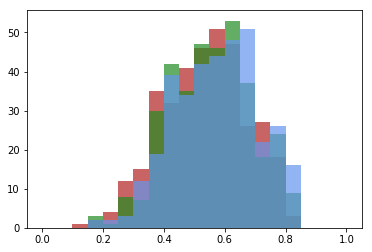

In [23]:
rest_r_cond = np.zeros(shape=(n_subjs, n_rois))
latent_r_cond = np.zeros(shape=(n_subjs, n_rois))
average_r_cond = np.zeros(shape=(n_subjs, n_rois))
for i, subj in enumerate(subjs):
    for k in np.arange(n_rois):
        actual = beta_dat[i,:,k]
        
        rest_prediction = all_cond_predicted_betas_rest[i,:,k]
        rest_r, _ = spearmanr(actual, rest_prediction)
        rest_r_cond[i,k] = rest_r
        
        latent_prediction = all_cond_predicted_betas_latent[i,:,k]
        latent_r, _ = spearmanr(actual, latent_prediction)
        latent_r_cond[i,k] = latent_r
        
        average_prediction = all_cond_predicted_betas_average[i,:,k]
        average_r, _ = spearmanr(actual, average_prediction)
        average_r_cond[i,k] = average_r
        
bins = np.linspace(0, 1, 21)
plt.hist(rest_r_cond.mean(axis=0), bins=bins, color='firebrick', alpha=0.7);
plt.hist(average_r_cond.mean(axis=0), bins=bins, color='forestgreen', alpha=0.7);
plt.hist(latent_r_cond.mean(axis=0), bins=bins, color='cornflowerblue', alpha=0.7);

21
VIS1: 0.33
VIS2: 0.11
SMN: 0.10
CON: 0.02
DAN: 0.09
LAN: 0.00
FPN: 0.10
AUD: 0.00
DMN: 0.00
PMM: 0.14
VMM: 0.00
ORA: 0.00
136
VIS1: 0.33
VIS2: 0.31
SMN: 0.21
CON: 0.38
DAN: 0.57
LAN: 0.48
FPN: 0.18
AUD: 0.73
DMN: 0.55
PMM: 0.00
VMM: 0.00
ORA: 0.33


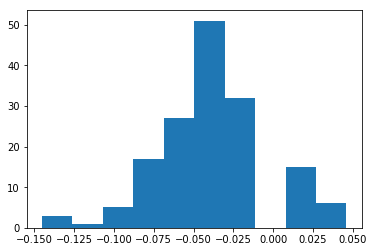

In [24]:
# Comparing Rest to Average FC
diff_r_cond_mean = rest_r_cond.mean(axis=0) - average_r_cond.mean(axis=0)
significant_diff_r_cond_mean = np.zeros(shape=(n_rois))
n_significant_diff_r_cond_rest = 0
n_significant_diff_r_cond_average = 0
significant_diff_average = np.zeros(n_rois)
significant_diff_rest = np.zeros(n_rois)
for k in np.arange(n_rois):
    t_stat, p_val = ttest_rel(np.arctanh(rest_r_cond[:,k]), np.arctanh(average_r_cond[:,k]))
    if p_val < 0.05/n_conds:
        significant_diff_r_cond_mean[k] = diff_r_cond_mean[k]
        if diff_r_cond_mean[k] < 0:
            n_significant_diff_r_cond_average += 1
            significant_diff_average[k] = 1
        elif diff_r_cond_mean[k] > 0:
            n_significant_diff_r_cond_rest += 1
            significant_diff_rest[k] = 1
    else:
        significant_diff_r_cond_mean[k] = np.nan
print(n_significant_diff_r_cond_rest)
calc_module_stats(significant_diff_rest)
print(n_significant_diff_r_cond_average)
calc_module_stats(significant_diff_average)
plt.hist(significant_diff_r_cond_mean[~np.isnan(significant_diff_r_cond_mean)])

if control_tp:
    outf = '%s/actflow_difference_rest_minus_average_r_conds_with_bonferroni_%s_%s_controltp' % (figdir, subj_group, data_group)
else:
    outf = '%s/actflow_difference_rest_minus_average_r_conds_with_bonferroni_%s_%s_alltp' % (figdir, subj_group, data_group)
#map_to_surface(significant_diff_r_cond_mean[networkorder].reshape(360,1), outf)

2
VIS1: 0.17
VIS2: 0.00
SMN: 0.00
CON: 0.00
DAN: 0.04
LAN: 0.00
FPN: 0.00
AUD: 0.00
DMN: 0.00
PMM: 0.00
VMM: 0.00
ORA: 0.00
251
VIS1: 0.33
VIS2: 0.69
SMN: 0.54
CON: 0.82
DAN: 0.65
LAN: 0.83
FPN: 0.58
AUD: 1.00
DMN: 0.79
PMM: 0.29
VMM: 0.25
ORA: 0.50


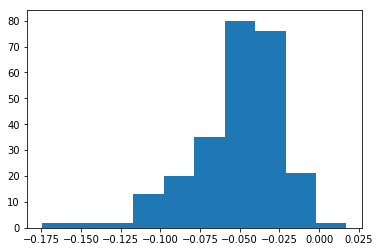

In [25]:
# Comparing Rest to Latent FC
diff_r_cond_mean = rest_r_cond.mean(axis=0) - latent_r_cond.mean(axis=0)
significant_diff_r_cond_mean = np.zeros(shape=(n_rois))
n_significant_diff_r_cond_rest = 0
n_significant_diff_r_cond_latent = 0
significant_diff_latent = np.zeros(n_rois)
significant_diff_rest = np.zeros(n_rois)
for k in np.arange(n_rois):
    t_stat, p_val = ttest_rel(np.arctanh(rest_r_cond[:,k]), np.arctanh(latent_r_cond[:,k]))
    if p_val < 0.05/n_conds:
        significant_diff_r_cond_mean[k] = diff_r_cond_mean[k]
        if diff_r_cond_mean[k] < 0:
            n_significant_diff_r_cond_latent += 1
            significant_diff_latent[k] = 1
        elif diff_r_cond_mean[k] > 0:
            n_significant_diff_r_cond_rest += 1
            significant_diff_rest[k] = 1
    else:
        significant_diff_r_cond_mean[k] = np.nan
print(n_significant_diff_r_cond_rest)
calc_module_stats(significant_diff_rest)
print(n_significant_diff_r_cond_latent)
calc_module_stats(significant_diff_latent)
plt.hist(significant_diff_r_cond_mean[~np.isnan(significant_diff_r_cond_mean)])

if control_tp:
    outf = '%s/actflow_difference_rest_minus_latent_r_conds_with_bonferroni_%s_%s_controltp' % (figdir, subj_group, data_group)
    
else:
    outf = '%s/actflow_difference_rest_minus_latent_r_conds_with_bonferroni_%s_%s_alltp' % (figdir, subj_group, data_group)
#map_to_surface(significant_diff_r_cond_mean[networkorder].reshape(360,1), outf)

In [ ]:
if control_tp:
    outfr = '%s/actflow_rest_r_conds_with_bonferroni_%s_%s_controltp' % (figdir, subj_group, data_group)
    outfl = '%s/actflow_latent_r_conds_with_bonferroni_%s_%s_controltp' % (figdir, subj_group, data_group)
else:
    outfr = '%s/actflow_rest_r_conds_with_bonferroni_%s_%s_alltp' % (figdir, subj_group, data_group)
    outfl = '%s/actflow_latent_r_conds_with_bonferroni_%s_%s_alltp' % (figdir, subj_group, data_group)
    
map_to_surface(rest_r_cond.mean(axis=0)[networkorder].reshape(360,1), outfr)
map_to_surface(latent_r_cond.mean(axis=0)[networkorder].reshape(360,1), outfl)

In [212]:
print(np.where(significant_diff_rest == 1))
print(np.where(significant_diff_latent == 1))

(array([ 6, 20, 33, 47]),)
(array([  0,   3,   8,   9,  10,  11,  14,  15,  16,  17,  18,  19,  22,
        23,  25,  26,  27,  28,  29,  31,  32,  35,  36,  37,  38,  42,
        43,  44,  45,  46,  49,  50,  51,  52,  53,  54,  56,  58,  59,
        63,  65,  66,  67,  71,  75,  76,  78,  79,  80,  82,  83,  84,
        85,  86,  87,  88,  89,  91,  93,  94,  95,  96,  97,  98,  99,
       100, 101, 102, 103, 104, 105, 107, 108, 111, 112, 113, 114, 117,
       118, 121, 122, 123, 124, 125, 126, 127, 129, 130, 132, 133, 134,
       135, 138, 141, 142, 143, 146, 147, 148, 149, 150, 151, 152, 153,
       154, 155, 156, 157, 158, 159, 161, 163, 166, 167, 168, 169, 170,
       172, 173, 174, 177, 180, 182, 183, 184, 185, 186, 187, 188, 189,
       191, 193, 194, 195, 196, 197, 200, 201, 203, 204, 205, 206, 207,
       209, 210, 211, 212, 213, 214, 216, 219, 221, 222, 225, 227, 228,
       229, 230, 231, 232, 233, 234, 238, 240, 242, 244, 245, 248, 251,
       252, 253, 254, 255, 256, 257,

2
VIS1: 0.00
VIS2: 0.00
SMN: 0.00
CON: 0.02
DAN: 0.00
LAN: 0.00
FPN: 0.00
AUD: 0.00
DMN: 0.01
PMM: 0.00
VMM: 0.00
ORA: 0.00
325
VIS1: 0.83
VIS2: 0.98
SMN: 1.00
CON: 0.95
DAN: 0.87
LAN: 0.91
FPN: 0.92
AUD: 0.80
DMN: 0.83
PMM: 1.00
VMM: 0.75
ORA: 0.33


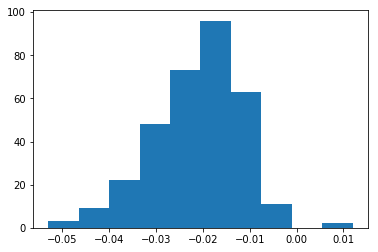

In [26]:
# Comparing Latent to Average FC
diff_r_cond_mean = average_r_cond.mean(axis=0) - latent_r_cond.mean(axis=0)
significant_diff_r_cond_mean = np.zeros(shape=(n_rois))
n_significant_diff_r_cond_average = 0
n_significant_diff_r_cond_latent = 0
significant_diff_latent = np.zeros(n_rois)
significant_diff_average = np.zeros(n_rois)
for k in np.arange(n_rois):
    t_stat, p_val = ttest_rel(np.arctanh(average_r_cond[:,k]), np.arctanh(latent_r_cond[:,k]))
    if p_val < 0.05/n_conds:
        significant_diff_r_cond_mean[k] = diff_r_cond_mean[k]
        if diff_r_cond_mean[k] < 0:
            n_significant_diff_r_cond_latent += 1
            significant_diff_latent[k] = 1
        elif diff_r_cond_mean[k] > 0:
            n_significant_diff_r_cond_average += 1
            significant_diff_average[k] = 1
    else:
        significant_diff_r_cond_mean[k] = np.nan
print(n_significant_diff_r_cond_average)
calc_module_stats(significant_diff_average)
print(n_significant_diff_r_cond_latent)
calc_module_stats(significant_diff_latent)
plt.hist(significant_diff_r_cond_mean[~np.isnan(significant_diff_r_cond_mean)])

if control_tp:
    outf = '%s/actflow_difference_average_minus_latent_r_conds_with_bonferroni_%s_%s_controltp' % (figdir, subj_group, data_group)
else:
    outf = '%s/actflow_difference_average_minus_latent_r_conds_with_bonferroni_%s_%s_alltp' % (figdir, subj_group, data_group)
#map_to_surface(significant_diff_r_cond_mean[networkorder].reshape(360,1), outf)

### Plot Average Within-Subject Comparisons per Condition

In [27]:
rest_r_allrois = np.zeros(shape=(n_subjs, n_conds))
average_r_allrois = np.zeros(shape=(n_subjs, n_conds))
latent_r_allrois = np.zeros(shape=(n_subjs, n_conds))
for i, subj in enumerate(subjs):
    for k in np.arange(n_conds):
        actual = beta_dat[i,k,:]
        
        rest_prediction = all_cond_predicted_betas_rest[i,k,:]
        rest_r, _ = spearmanr(actual, rest_prediction, nan_policy='omit')
        rest_r_allrois[i,k] = rest_r
        
        latent_prediction = all_cond_predicted_betas_latent[i,k,:]
        latent_r, _ = spearmanr(actual, latent_prediction, nan_policy='omit')
        latent_r_allrois[i,k] = latent_r
        
        average_prediction = all_cond_predicted_betas_average[i,k,:]
        average_r, _ = spearmanr(actual, average_prediction, nan_policy='omit')
        average_r_allrois[i,k] = average_r

In [28]:
print(np.column_stack((conds, np.nanmean(rest_r_allrois, axis=0))))

[['emotion_fear' 0.45736062135253125]
 ['emotion_neut' 0.428737878986627]
 ['gambling_win' 0.5740873552966526]
 ['gambling_loss' 0.5703769795618983]
 ['language_story' 0.5520836855269414]
 ['language_math' 0.5106378895553583]
 ['motor_cue' 0.5273891542957564]
 ['motor_lf' 0.4287513675633956]
 ['motor_rf' 0.4332165438870062]
 ['motor_lh' 0.38458087470044533]
 ['motor_rh' 0.3905350876023874]
 ['motor_t' 0.39897610303530656]
 ['relational_relation' 0.5458174363952959]
 ['relational_match' 0.5951154853070088]
 ['social_mental' 0.5460686118158878]
 ['social_rnd' 0.6363241541449415]
 ['wm_0bk_body' 0.42215560404623387]
 ['wm_0bk_faces' 0.3973445975663394]
 ['wm_0bk_places' 0.4654124818466844]
 ['wm_0bk_tools' 0.5199840542517282]
 ['wm_2bk_body' 0.47019143052450585]
 ['wm_2bk_faces' 0.4544738101818498]
 ['wm_2bk_places' 0.48666022722304003]
 ['wm_2bk_tools' 0.4877573556146499]]


In [29]:
print(np.column_stack((conds, np.nanmean(average_r_allrois, axis=0))))

[['emotion_fear' 0.49507948264424956]
 ['emotion_neut' 0.44199082361746594]
 ['gambling_win' 0.6832109219417379]
 ['gambling_loss' 0.6668857413204881]
 ['language_story' 0.5699793310577822]
 ['language_math' 0.5613176378325027]
 ['motor_cue' 0.5941256941282979]
 ['motor_lf' 0.4371021483634715]
 ['motor_rf' 0.44839391092617403]
 ['motor_lh' 0.37932004917499573]
 ['motor_rh' 0.3836020833610997]
 ['motor_t' 0.41820359134598656]
 ['relational_relation' 0.635943279409423]
 ['relational_match' 0.6625142324213592]
 ['social_mental' 0.5696406406404649]
 ['social_rnd' 0.6659615107626862]
 ['wm_0bk_body' 0.46928646831824145]
 ['wm_0bk_faces' 0.43803109919245087]
 ['wm_0bk_places' 0.504660170287509]
 ['wm_0bk_tools' 0.5503245939046946]
 ['wm_2bk_body' 0.5529182689283749]
 ['wm_2bk_faces' 0.5295751498737247]
 ['wm_2bk_places' 0.5575316179254094]
 ['wm_2bk_tools' 0.584373833084664]]


In [30]:
print(np.column_stack((conds, np.nanmean(latent_r_allrois, axis=0))))

[['emotion_fear' 0.5093964772338544]
 ['emotion_neut' 0.4550434110041534]
 ['gambling_win' 0.6874854007711902]
 ['gambling_loss' 0.6670744761755788]
 ['language_story' 0.584294140877911]
 ['language_math' 0.567607387484518]
 ['motor_cue' 0.5913538982834461]
 ['motor_lf' 0.4482573431052009]
 ['motor_rf' 0.4589476218250843]
 ['motor_lh' 0.3866017265495174]
 ['motor_rh' 0.39319673599239785]
 ['motor_t' 0.42853311713029957]
 ['relational_relation' 0.6395127952376174]
 ['relational_match' 0.6622421226711669]
 ['social_mental' 0.5953306624489947]
 ['social_rnd' 0.6808572164441037]
 ['wm_0bk_body' 0.48430953071560817]
 ['wm_0bk_faces' 0.4510137008866746]
 ['wm_0bk_places' 0.5118179675792488]
 ['wm_0bk_tools' 0.5625316082802732]
 ['wm_2bk_body' 0.5603494356835433]
 ['wm_2bk_faces' 0.543280574146312]
 ['wm_2bk_places' 0.5680371645217055]
 ['wm_2bk_tools' 0.5873506099934834]]


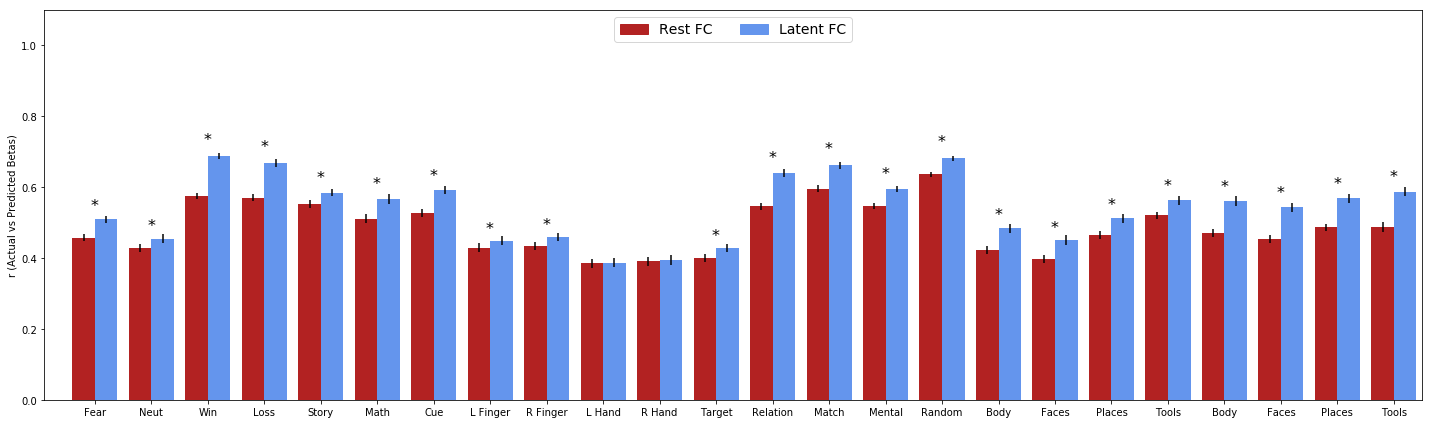

In [31]:
plt.figure(figsize=(20,6));
plt.ylim(0, 1.1);
plt.xlim(-0.7, 23.7);

barWidth = 0.4
r1 = np.arange(n_conds)
r2 = [x + barWidth for x in r1]
r3 = [x + (barWidth/2) for x in r1]

plt.bar(r1, np.nanmean(rest_r_allrois, axis=0),    color='firebrick',      width=barWidth, yerr=sem(rest_r_allrois,    axis=0, nan_policy='omit'), ecolor='k');
plt.bar(r2, np.nanmean(latent_r_allrois, axis=0),  color='cornflowerblue', width=barWidth, yerr=sem(latent_r_allrois,  axis=0, nan_policy='omit'), ecolor='k');

plt.xticks(r3, condname, rotation=0, fontsize=10);
plt.ylabel('r (Actual vs Predicted Betas)', fontsize=10);
plot_significant_difference(rest_r_allrois, latent_r_allrois, barWidth=barWidth, r1=r1, r2=r2, adjust_x2=.125);
red_patch = mpatches.Patch(color='firebrick', label='Rest FC')
blue_patch = mpatches.Patch(color='cornflowerblue', label='Latent FC')
plt.legend(handles=[red_patch, blue_patch], loc='upper center', fontsize=14, ncol=2)
plt.tight_layout()

if control_tp:
    plotname = '%s/actflowconditions_restlatent_%s_%s_controltp' % (figdir, subj_group, data_group)
else:
    plotname = '%s/actflowconditions_restlatent_%s_%s_alltp' % (figdir, subj_group, data_group)
plt.savefig('%s.pdf' % plotname)
plt.savefig('%s.png' % plotname, dpi=300, transparent=True)

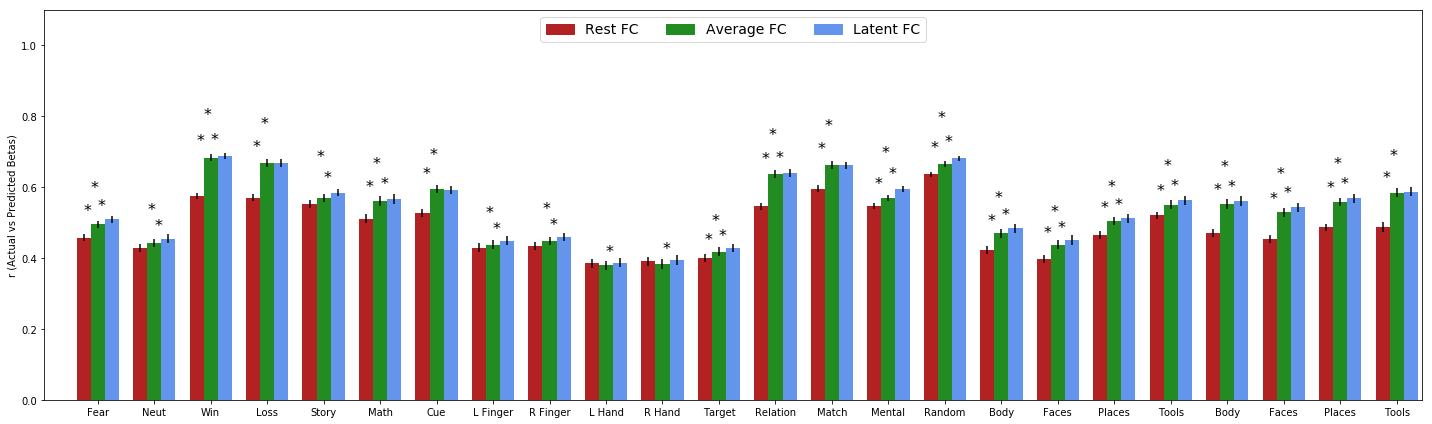

In [32]:
plt.figure(figsize=(20,6));
plt.ylim(0, 1.1);
plt.xlim(-0.7, 23.7);

barWidth = 0.25
r1 = np.arange(n_conds)
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
#r4 = [x + barWidth for x in r3]

plt.bar(r1, np.nanmean(rest_r_allrois, axis=0),    color='firebrick',      width=barWidth, yerr=sem(rest_r_allrois,    axis=0, nan_policy='omit'), ecolor='k');
plt.bar(r2, np.nanmean(average_r_allrois, axis=0), color='forestgreen',    width=barWidth, yerr=sem(average_r_allrois, axis=0, nan_policy='omit'), ecolor='k');
plt.bar(r3, np.nanmean(latent_r_allrois, axis=0),  color='cornflowerblue', width=barWidth, yerr=sem(latent_r_allrois,  axis=0, nan_policy='omit'), ecolor='k');
plt.xticks(r2, condname, rotation=0, fontsize=10);
plt.ylabel('r (Actual vs Predicted Betas)', fontsize=10);

plot_significant_difference(rest_r_allrois, average_r_allrois, barWidth=barWidth, r1=r1, r2=r2);
plot_significant_difference(average_r_allrois, latent_r_allrois, barWidth=barWidth, r1=r2, r2=r3);
plot_significant_difference(rest_r_allrois, latent_r_allrois, barWidth=barWidth, r1=r1, r2=r3, adjust_y=3);

red_patch = mpatches.Patch(color='firebrick', label='Rest FC')
green_patch = mpatches.Patch(color='forestgreen', label='Average FC')
blue_patch = mpatches.Patch(color='cornflowerblue', label='Latent FC')
plt.legend(handles=[red_patch, green_patch, blue_patch], loc='upper center', fontsize=14, ncol=3)
plt.tight_layout()

if control_tp:
    plotname = '%s/actflowconditions_restaveragelatent_%s_%s_controltp' % (figdir, subj_group, data_group)
else:
    plotname = '%s/actflowconditions_restaveragelatent_%s_%s_alltp' % (figdir, subj_group, data_group)
plt.savefig('%s.pdf' % plotname)
plt.savefig('%s.png' % plotname, dpi=300, transparent=True)

In [ ]:
# (array([ 6, 20, 33, 47]),)
# (array([  0,   3,   8,   9,  10,  11,  14,  15,  16,  17,  18,  19,  22,
#         23,  25,  26,  27,  28,  29,  31,  32,  35,  36,  37,  38,  42,
#         43,  44,  45,  46,  49,  50,  51,  52,  53,  54,  56,  58,  59,
#         63,  65,  66,  67,  71,  75,  76,  78,  79,  80,  82,  83,  84,
#         85,  86,  87,  88,  89,  91,  93,  94,  95,  96,  97,  98,  99,
#        100, 101, 102, 103, 104, 105, 107, 108, 111, 112, 113, 114, 117,
#        118, 121, 122, 123, 124, 125, 126, 127, 129, 130, 132, 133, 134,
#        135, 138, 141, 142, 143, 146, 147, 148, 149, 150, 151, 152, 153,
#        154, 155, 156, 157, 158, 159, 161, 163, 166, 167, 168, 169, 170,
#        172, 173, 174, 177, 180, 182, 183, 184, 185, 186, 187, 188, 189,
#        191, 193, 194, 195, 196, 197, 200, 201, 203, 204, 205, 206, 207,
#        209, 210, 211, 212, 213, 214, 216, 219, 221, 222, 225, 227, 228,
#        229, 230, 231, 232, 233, 234, 238, 240, 242, 244, 245, 248, 251,
#        252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264,
#        265, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278,
#        279, 280, 281, 282, 283, 284, 285, 286, 288, 291, 293, 294, 295,
#        296, 297, 299, 300, 301, 302, 303, 304, 308, 309, 310, 311, 312,
#        313, 314, 315, 318, 319, 320, 321, 322, 323, 324, 325, 326, 329,
#        331, 333, 334, 335, 338, 339, 340, 341, 342, 346, 355, 357]),)

In [253]:
roi_num = 47
rest_r_targetrois = np.zeros(shape=(n_conds))
average_r_targetrois = np.zeros(shape=(n_conds))
latent_r_targetrois = np.zeros(shape=(n_conds))
for k in np.arange(n_conds):
    actual = beta_dat[:,k,roi_num]

    rest_prediction = all_cond_predicted_betas_rest[:,k,roi_num]
    rest_r, _ = spearmanr(actual, rest_prediction, nan_policy='omit')
    rest_r_targetrois[k] = rest_r

    latent_prediction = all_cond_predicted_betas_latent[:,k,roi_num]
    latent_r, _ = spearmanr(actual, latent_prediction, nan_policy='omit')
    latent_r_targetrois[k] = latent_r

    average_prediction = all_cond_predicted_betas_average[:,k,roi_num]
    average_r, _ = spearmanr(actual, average_prediction, nan_policy='omit')
    average_r_targetrois[k] = average_r

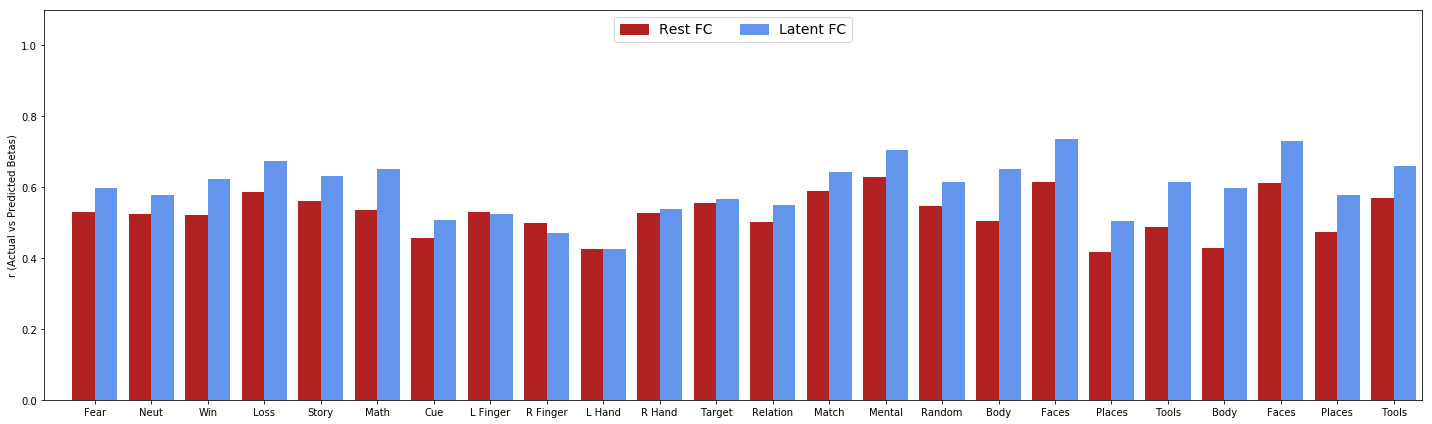

In [256]:
plt.figure(figsize=(20,6));
plt.ylim(0, 1.1);
plt.xlim(-0.7, 23.7);

barWidth = 0.4
r1 = np.arange(n_conds)
r2 = [x + barWidth for x in r1]
r3 = [x + (barWidth/2) for x in r1]

plt.bar(r1, rest_r_targetrois,    color='firebrick',      width=barWidth, ecolor='k');
plt.bar(r2, latent_r_targetrois,  color='cornflowerblue', width=barWidth, ecolor='k');

plt.xticks(r3, condname, rotation=0, fontsize=10);
plt.ylabel('r (Actual vs Predicted Betas)', fontsize=10);
red_patch = mpatches.Patch(color='firebrick', label='Rest FC')
blue_patch = mpatches.Patch(color='cornflowerblue', label='Latent FC')
plt.legend(handles=[red_patch, blue_patch], loc='upper center', fontsize=14, ncol=2)
plt.tight_layout()

if control_tp:
    plotname = '%s/actflowconditions_targetroi_%s_restlatent_%s_%s_controltp' % (figdir, roi_num, subj_group, data_group)
else:
    plotname = '%s/actflowconditions_targetroi_%s_restlatent_%s_%s_alltp' % (figdir, roi_num, subj_group, data_group)
#plt.savefig('%s.pdf' % plotname)
#plt.savefig('%s.png' % plotname, dpi=300, transparent=True)

## G Prediction

### Run LOSO Prediction

In [160]:
behavdir = '/projects/f_mc1689_1/LatentFC/data/hcpbehavior/results/fa'
subj_group_g = 'overall'

subjsf_g = '%s/%s_subjects.npy' % (homedir, subj_group_g)
subjs_g = np.load(subjsf_g)
subjs_g = np.array(subjs_g, dtype=int).tolist()

def model_g_from_connectivity(df, g_df, model):
    x_predictors = np.array(df)
    y = np.array(g_df)
    if model == 'linear':
        lm = LinearRegression()
        return lm.fit(x_predictors, y)
    elif model == 'ridge':
        ridge = Ridge()
        return ridge.fit(x_predictors, y)


def loso_predict_g_from_connectivity(df, g_df, subjs, model):
    '''
    df : pd.DataFrame
      Training data: index=subjects, columns=parameters (e.g. connectivity)
    g_df : pd.DataFrame
      Intelligence factor data: index=subjects, columns='g'
    subjs : list
      List of subjects
    '''
    df = df.loc[subjs]
    g_df = g_df.loc[subjs]
    loso_pred = pd.DataFrame(columns=['g_pred'])
    for subj in subjs:
        loso_subjs = list(subjs)
        loso_subjs.remove(subj)
        loso_df = df.loc[loso_subjs]
        loso_g_df = g_df.loc[loso_subjs]
        loso_model = model_g_from_connectivity(loso_df, loso_g_df, model=model)
        subj_dat = np.matrix(df.loc[subj])
        loso_pred.loc[subj] = loso_model.predict(subj_dat)[0]
    r2 = r2_score(g_df['g'], loso_pred['g_pred'])
    mse = mean_squared_error(g_df['g'], loso_pred['g_pred'])
    return r2, loso_pred

if subj_group_g == 'overall':
    eid_rd = 0.12
    eid_t = 2.327
    eid_p = 0.01
elif subj_group_g == 'exploratory':
    eid_rd = 0.30
    eid_t = 6.025
    eid_p = 0.001
elif subj_group_g == 'validation':
    eid_rd = 0.08
    eid_t = 1.209
    eid_p = 0.113

In [161]:
rest_df = pd.DataFrame(index=subjs_g, columns=np.arange(n_connections))
for subj in subjs_g:
    rest_mat = get_subject_full_rest_adjmat(subj, control_tp=False)
    rest_df.loc[subj] = rest_mat[np.triu_indices(n_rois,1)]
rest_df.shape

/projects/f_mc1689_1/AnalysisTools/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: divide by zero encountered in arctanh


(352, 64620)

In [162]:
average_df = pd.DataFrame(index=subjs_g, columns=np.arange(n_connections))
for subj in subjs_g:
    average_mat = get_subject_average_mat(subj, datadir='%s/Results/fa/correlation/%s/overall/' % (homedir, subj_group_g))
    average_df.loc[subj] = average_mat[np.triu_indices(n_rois,1)]
average_df.shape

(352, 64620)

In [163]:
latent_df = pd.DataFrame(index=subjs_g, columns=np.arange(n_connections))
for subj in subjs_g:
    latent_mat = get_subject_latent_mat(subj, datadir='%s/Results/fa/correlation/%s/overall' % (homedir, subj_group_g))
    latent_df.loc[subj] = latent_mat[np.triu_indices(n_rois,1)]
latent_df.shape

(352, 64620)

In [170]:
g_df = pd.read_excel('%s/%s/%s_factor_scores_nfactors_1.xlsx' % (behavdir, subj_group_g, subj_group_g), index_col=0)
g_df.shape

(351, 1)

In [173]:
subjs_g = np.array(g_df.index).tolist()

In [172]:
rest_r2, rest_loso_g = loso_predict_g_from_connectivity(rest_df, g_df, subjs_g, 'linear')
print(rest_r2)
print(pearsonr(np.squeeze(g_df.loc[subjs_g].values), np.squeeze(rest_loso_g.loc[subjs_g].values)))
print(spearmanr(np.squeeze(g_df.loc[subjs_g].values), np.squeeze(rest_loso_g.loc[subjs_g].values)))

KeyboardInterrupt: 

In [ ]:
average_r2, average_loso_g = loso_predict_g_from_connectivity(average_df, g_df, subjs_g, 'linear')
print(average_r2)
print(pearsonr(np.squeeze(g_df.loc[subjs_g].values), np.squeeze(average_loso_g.loc[subjs_g].values)))
print(spearmanr(np.squeeze(g_df.loc[subjs_g].values), np.squeeze(average_loso_g.loc[subjs_g].values)))

In [ ]:
latent_r2, latent_loso_g = loso_predict_g_from_connectivity(latent_df, g_df, subjs_g, 'linear')
print(latent_r2)
print(pearsonr(np.squeeze(g_df.loc[subjs_g].values), np.squeeze(latent_loso_g.loc[subjs_g].values)))
print(spearmanr(np.squeeze(g_df.loc[subjs_g].values), np.squeeze(latent_loso_g.loc[subjs_g].values)))

In [ ]:
print(pearsonr(np.squeeze(g_df.loc[subjs_g].values), np.squeeze(rest_loso_g.loc[subjs_g].values)))
print(pearsonr(np.squeeze(g_df.loc[subjs_g].values), np.squeeze(latent_loso_g.loc[subjs_g].values)))
print(pearsonr(np.squeeze(rest_loso_g.loc[subjs_g].values), np.squeeze(latent_loso_g.loc[subjs_g].values)))

In [174]:
rest_r2, rest_loso_g = loso_predict_g_from_connectivity(rest_df, g_df, subjs_g, 'ridge')
print(rest_r2)
print(pearsonr(np.squeeze(g_df.loc[subjs_g].values), np.squeeze(rest_loso_g.loc[subjs_g].values)))
print(spearmanr(np.squeeze(g_df.loc[subjs_g].values), np.squeeze(rest_loso_g.loc[subjs_g].values)))

0.07577403072820044
(0.3279764252119973, 3.0197191647708674e-10)
SpearmanrResult(correlation=0.3091880341880342, pvalue=3.266872120449309e-09)


In [175]:
average_r2, average_loso_g = loso_predict_g_from_connectivity(average_df, g_df, subjs_g, 'ridge')
print(average_r2)
print(pearsonr(np.squeeze(g_df.loc[subjs_g].values), np.squeeze(average_loso_g.loc[subjs_g].values)))
print(spearmanr(np.squeeze(g_df.loc[subjs_g].values), np.squeeze(average_loso_g.loc[subjs_g].values)))

0.17454209347027305
(0.45584004327246574, 2.0626685304088548e-19)
SpearmanrResult(correlation=0.43979631479631476, pvalue=4.918740305815058e-18)


In [176]:
latent_r2, latent_loso_g = loso_predict_g_from_connectivity(latent_df, g_df, subjs_g, 'ridge')
print(latent_r2)
print(pearsonr(np.squeeze(g_df.loc[subjs_g].values), np.squeeze(latent_loso_g.loc[subjs_g].values)))
print(spearmanr(np.squeeze(g_df.loc[subjs_g].values), np.squeeze(latent_loso_g.loc[subjs_g].values)))

0.15584866241451645
(0.44903043215533656, 8.090299188824227e-19)
SpearmanrResult(correlation=0.4336108336108336, pvalue=1.598603939728259e-17)


In [ ]:
print(pearsonr(np.squeeze(g_df.loc[subjs_g].values), np.squeeze(rest_loso_g.loc[subjs_g].values)))
print(pearsonr(np.squeeze(g_df.loc[subjs_g].values), np.squeeze(latent_loso_g.loc[subjs_g].values)))
print(pearsonr(np.squeeze(rest_loso_g.loc[subjs_g].values), np.squeeze(latent_loso_g.loc[subjs_g].values)))

In [177]:
rest_loso_g.to_csv('%s/Results/fa/correlation/%s/overall/g_pred_rest_%s.csv' % (homedir, subj_group_g, subj_group_g), sep=',')
average_loso_g.to_csv('%s/Results/fa/correlation/%s/overall/g_pred_average_%s.csv' % (homedir, subj_group_g, subj_group_g), sep=',')
latent_loso_g.to_csv('%s/Results/fa/correlation/%s/overall/g_pred_latent_%s.csv' % (homedir, subj_group_g, subj_group_g), sep=',')

In [6]:
rest_loso_g = pd.read_csv('%s/Results/fa/correlation/%s/overall/g_pred_rest_%s.csv' % (homedir, subj_group_g, subj_group_g), index_col=0)
average_loso_g = pd.read_csv('%s/Results/fa/correlation/%s/overall/g_pred_average_%s.csv' % (homedir, subj_group_g, subj_group_g), index_col=0)
latent_loso_g = pd.read_csv('%s/Results/fa/correlation/%s/overall/g_pred_latent_%s.csv' % (homedir, subj_group_g, subj_group_g), index_col=0)

In [17]:
from scipy.spatial import distance
from scipy import special

print(distance.euclidean(g_df.loc[subjs_g].values,rest_loso_g))
print(distance.euclidean(g_df.loc[subjs_g].values,average_loso_g))
print(distance.euclidean(g_df.loc[subjs_g].values,latent_loso_g))

print(np.mean(special.kl_div(np.squeeze(g_df.loc[subjs_g].values),np.squeeze(rest_loso_g.values))))

11.587010616745324
9.740910679389138
9.74428015271502
inf


### Plot Predictions

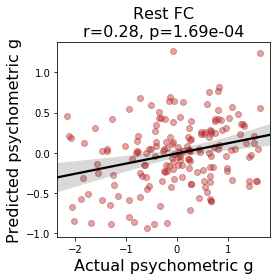

In [15]:
g_vals = np.squeeze(g_df.loc[subjs_g].values)
rest_pred_g_vals = np.squeeze(rest_loso_g.values)

plt.figure(figsize=(4,4))
r, p = pearsonr(g_vals, rest_pred_g_vals)
sns.regplot(g_vals, rest_pred_g_vals, scatter_kws={'color': 'firebrick', 'alpha': .4}, line_kws={'color': 'k'})

plt.title('Rest FC\nr=%.2f, p=%.2e' % (r, p), fontsize=16)
plt.xlabel('Actual psychometric g', fontsize=16)
plt.ylabel('Predicted psychometric g', fontsize=16)
plt.tight_layout()

plotname = '%s/predictg_rest_%s' % (figdir, subj_group_g)
plt.savefig('%s.pdf' % plotname)
plt.savefig('%s.png' % plotname, dpi=300, transparent=True)

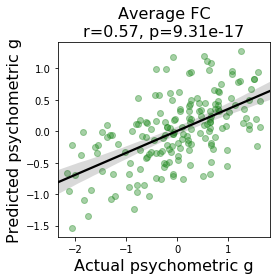

In [16]:
g_vals = np.squeeze(g_df.loc[subjs_g].values)
average_pred_g_vals = np.squeeze(average_loso_g.values)

plt.figure(figsize=(4,4))
r, p = pearsonr(g_vals, average_pred_g_vals)
sns.regplot(g_vals, average_pred_g_vals, scatter_kws={'color': 'forestgreen', 'alpha': .4}, line_kws={'color': 'k'})

plt.title('Average FC\nr=%.2f, p=%.2e' % (r, p), fontsize=16)
plt.xlabel('Actual psychometric g', fontsize=16)
plt.ylabel('Predicted psychometric g', fontsize=16)
plt.tight_layout()

plotname = '%s/predictg_average_%s' % (figdir, subj_group_g)
plt.savefig('%s.pdf' % plotname)
plt.savefig('%s.png' % plotname, dpi=300, transparent=True)

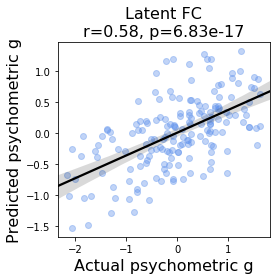

In [17]:
g_vals = np.squeeze(g_df.loc[subjs_g].values)
latent_pred_g_vals = np.squeeze(latent_loso_g.values)

plt.figure(figsize=(4,4))
r, p = pearsonr(g_vals, latent_pred_g_vals)
sns.regplot(g_vals, latent_pred_g_vals, scatter_kws={'color': 'cornflowerblue', 'alpha': .4}, line_kws={'color': 'k'})

plt.title('Latent FC\nr=%.2f, p=%.2e' % (r, p), fontsize=16)
plt.xlabel('Actual psychometric g', fontsize=16)
plt.ylabel('Predicted psychometric g', fontsize=16)
plt.tight_layout()

plotname = '%s/predictg_latent_%s' % (figdir, subj_group_g)
plt.savefig('%s.pdf' % plotname)
plt.savefig('%s.png' % plotname, dpi=300, transparent=True)

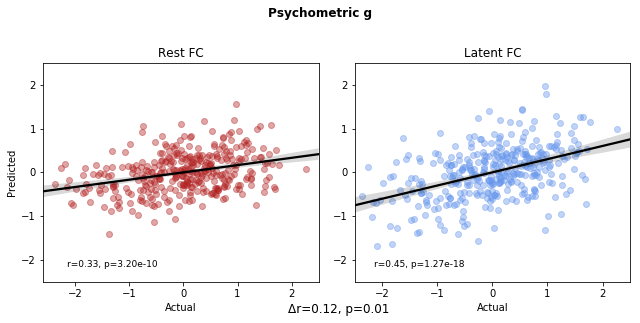

In [25]:
g_vals = np.squeeze(g_df.loc[subjs_g].values)
rest_pred_g_vals = np.squeeze(rest_loso_g.values)

plt.figure(figsize=(9,4))
plt.suptitle('Psychometric g', fontsize=12, fontweight='bold', y=1.1)

plt.subplot(121)
r, p = pearsonr(g_vals, rest_pred_g_vals)
#plt.scatter(g_vals, rest_pred_g_vals, s=25, alpha=0.4, color='indianred')
plt.title('Rest FC', fontsize=12)
plt.xlabel('Actual', fontsize=10)
plt.ylabel('Predicted', fontsize=10)
plt.text(-2.15,-2.15, 'r=%.2f, p=%.2e' % (r, p), fontsize=9)
#plt.xlim(-2.5,2.5)
plt.ylim(-2.5,2.5)
sns.regplot(g_vals, rest_pred_g_vals, scatter_kws={'color': 'firebrick', 'alpha': .4}, line_kws={'color': 'k'})

plt.subplot(122)
r, p = pearsonr(g_vals, latent_pred_g_vals)

plt.title('Latent FC', fontsize=12)
plt.xlabel('Actual', fontsize=10)
#plt.ylabel('Predicted psychometric g', fontsize=12)
plt.text(-2.15,-2.15, 'r=%.2f, p=%.2e' % (r, p), fontsize=9)
plt.xlim(-2.5,2.5)
plt.ylim(-2.5,2.5)
sns.regplot(g_vals, latent_pred_g_vals, scatter_kws={'color': 'cornflowerblue', 'alpha': .4}, line_kws={'color': 'k'})

plt.tight_layout()
if subj_group_g == 'exploratory':
    plt.text(-4, -3.2, '\u0394r=%.2f, p=<%.3f' % (eid_rd, eid_p), fontsize=12);
elif subj_group_g == 'validation':
    plt.text(-3.8, -3.2, '\u0394r=%.2f, p=%.2f' % (eid_rd, eid_p), fontsize=12);
elif subj_group_g == 'overall':
    plt.text(-3.7, -3.2, '\u0394r=%.2f, p=%.2f' % (eid_rd, eid_p), fontsize=12);

plotname = '%s/predictg_restlatent_%s' % (figdir, subj_group_g)
plt.savefig('%s.pdf' % plotname)
plt.savefig('%s.png' % plotname, dpi=300, transparent=True)

In [5]:
control_tp_loadings = False
if control_tp_loadings:
    tmpdatdir = '%s/Results/fa/correlation/%s/overall/control_tp' % (homedir, subj_group)
else:
    tmpdatdir = '%s/Results/fa/correlation/%s/overall' % (homedir, subj_group)

latent_dat = pd.DataFrame(index=subjs, columns=np.arange(n_connections))
for subj in subjs:
    latent_mat = get_subject_latent_mat(subj, datadir=tmpdatdir)
    latent_dat.loc[subj] = latent_mat[np.triu_indices(n_rois,1)]
latent_dat.shape

(176, 64620)

In [7]:
average_dat = pd.DataFrame(index=subjs, columns=np.arange(n_connections))
for subj in subjs:
    average_mat = get_subject_average_mat(subj, datadir=tmpdatdir)
    average_dat.loc[subj] = average_mat[np.triu_indices(n_rois,1)]
average_dat.shape

(176, 64620)

In [8]:
print(pearsonr(latent_dat.to_numpy().flatten(), average_dat.to_numpy().flatten()))

(0.9812439624707696, 0.0)


In [ ]:
print(pearsonr(np.mean(latent_dat, axis=0), np.mean(average_dat, axis=0)))

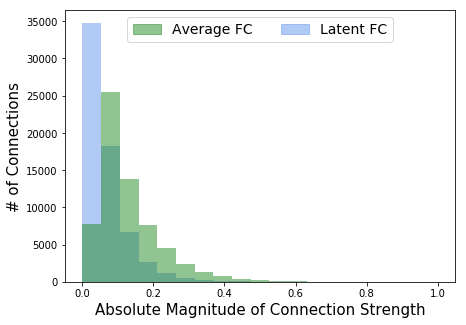

In [20]:
plt.figure(figsize=(7,5))

plt.hist(np.mean(np.abs(latent_dat), axis=0), bins=np.linspace(0, 1, 20), color='cornflowerblue', alpha=.5);
plt.hist(np.mean(np.abs(average_dat), axis=0), bins=np.linspace(0, 1, 20), color='forestgreen', alpha=.5);

green_patch = mpatches.Patch(color='forestgreen', label='Average FC', alpha=.5)
blue_patch = mpatches.Patch(color='cornflowerblue', label='Latent FC', alpha=.5)
plt.legend(handles=[green_patch, blue_patch], loc='upper center', fontsize=14, ncol=2)

plt.ylabel('# of Connections', fontsize=15);
plt.xlabel('Absolute Magnitude of Connection Strength', fontsize=15);

plotname = '%s/connectionsparsity_averagelatent_%s' % (figdir, subj_group)
plt.savefig('%s.pdf' % plotname)
plt.savefig('%s.png' % plotname, dpi=300, transparent=True)

In [9]:
np.mean(latent_dat, axis=0).shape

(64620,)

### Conduct Meta-Analysis

In [47]:
g_df_exploratory = pd.read_excel('%s/exploratory/exploratory_factor_scores_nfactors_1.xlsx' % (behavdir), index_col=0)
subjs_g_exploratory = np.array(g_df_exploratory.index).tolist()
g_df_validation = pd.read_excel('%s/validation/validation_factor_scores_nfactors_1.xlsx' % (behavdir), index_col=0)
subjs_g_validation = np.array(g_df_validation.index).tolist()

rest_loso_g_exploratory = pd.read_csv('%s/Results/fa/correlation/exploratory/overall/g_pred_rest_exploratory.csv' % (homedir), index_col=0)
latent_loso_g_exploratory = pd.read_csv('%s/Results/fa/correlation/exploratory/overall/g_pred_latent_exploratory.csv' % (homedir), index_col=0)

rest_loso_g_validation = pd.read_csv('%s/Results/fa/correlation/validation/overall/g_pred_rest_validation.csv' % (homedir), index_col=0)
latent_loso_g_validation = pd.read_csv('%s/Results/fa/correlation/validation/overall/g_pred_latent_validation.csv' % (homedir), index_col=0)

In [66]:
r12_explor, _ = pearsonr(np.squeeze(g_df_exploratory.loc[subjs_g_exploratory].values), np.squeeze(rest_loso_g_exploratory.values))
r13_explor, _ = pearsonr(np.squeeze(g_df_exploratory.loc[subjs_g_exploratory].values), np.squeeze(latent_loso_g_exploratory.values))
delta_r_explor = r13_explor - r12_explor

r12_valid, _ = pearsonr(np.squeeze(g_df_validation.loc[subjs_g_validation].values), np.squeeze(rest_loso_g_validation.values))
r13_valid, _ = pearsonr(np.squeeze(g_df_validation.loc[subjs_g_validation].values), np.squeeze(latent_loso_g_validation.values))
delta_r_valid = r13_valid - r12_valid

print(delta_r_explor, delta_r_valid)
p = np.array([0.000018, 0.113406])

0.29545598709541815 0.07116331244887059


In [91]:
z = np.arctanh(np.array([delta_r_explor, delta_r_valid]))
zw = np.sum([(len(subjs_g_exploratory)*z[0]), (len(subjs_g_validation)*z[1])]) / np.sum([len(subjs_g_exploratory), len(subjs_g_validation)])
print(zw)

0.18824097408124116


In [73]:
from scipy.stats import chi2
print('%.10f' % chi2.pdf(-2*np.sum((np.log(p))), p.shape[0]*2))

0.0000133725


### New LOOCV Approach

In [131]:
behavdir = '/projects/f_mc1689_1/LatentFC/data/hcpbehavior/results/fa'

subj_group_g_expl = 'exploratory'
subjsf_g_expl = '%s/%s_subjects.npy' % (homedir, subj_group_g_expl)
subjs_g_expl = np.load(subjsf_g_expl)
subjs_g_expl = np.array(subjs_g_expl, dtype=int).tolist()

subj_group_g_val = 'validation'
subjsf_g_val = '%s/%s_subjects.npy' % (homedir, subj_group_g_val)
subjs_g_val = np.load(subjsf_g_val)
subjs_g_val = np.array(subjs_g_val, dtype=int).tolist()


def model_g_from_connectivity(df, g_df, model):
    x_predictors = np.array(df)
    y = np.array(g_df)
    if model == 'linear':
        lm = LinearRegression()
        return lm.fit(x_predictors, y)
    elif model == 'ridge':
        ridge = Ridge()
        return ridge.fit(x_predictors, y)


def loso_predict_g_from_connectivity(df, g_df, subjs, model):
    '''
    df : pd.DataFrame
      Connectivity data: index=subjects, columns=parameters
    g_df : pd.DataFrame
      Intelligence factor data: index=subjects, columns='g'
    subjs : list
      List of subjects
    '''
    subjlist = subjs.index
    df = df.loc[subjlist]    
    loso_pred = pd.DataFrame(columns=['g_pred'])
    
    for subj in subjlist:
        test_sample = subjs.loc[subj][0]
        df_train = df.loc[subjs[subjs['sample'] != test_sample].index]
        g_df_train = g_df.loc[subjs[subjs['sample'] != test_sample].index]
        loso_model = model_g_from_connectivity(df_train, g_df_train, model=model)
        subj_dat = np.matrix(df.loc[subj])
        loso_pred.loc[subj] = loso_model.predict(subj_dat)[0] 
    
    return loso_pred

In [142]:
rest_df = pd.DataFrame(index=subjs_g_expl + subjs_g_val, columns=np.arange(n_connections))
for subj in subjs_g_expl + subjs_g_val:
    rest_mat = get_subject_full_rest_adjmat(subj, control_tp=False)
    rest_df.loc[subj] = rest_mat[np.triu_indices(n_rois,1)]
rest_df.shape

/projects/f_mc1689_1/AnalysisTools/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: divide by zero encountered in arctanh


(351, 64620)

In [143]:
average_df = pd.DataFrame(index=subjs_g_expl + subjs_g_val, columns=np.arange(n_connections))
for subj in subjs_g_expl:
    average_mat = get_subject_average_mat(subj, datadir='%s/Results/fa/correlation/%s/overall/' % (homedir, subj_group_g_expl))
    average_df.loc[subj] = average_mat[np.triu_indices(n_rois,1)]
for subj in subjs_g_val:
    average_mat = get_subject_average_mat(subj, datadir='%s/Results/fa/correlation/%s/overall/' % (homedir, subj_group_g_val))
    average_df.loc[subj] = average_mat[np.triu_indices(n_rois,1)]
average_df.shape

(351, 64620)

In [144]:
latent_df = pd.DataFrame(index=subjs_g_expl + subjs_g_val, columns=np.arange(n_connections))
for subj in subjs_g_expl:
    latent_mat = get_subject_latent_mat(subj, datadir='%s/Results/fa/correlation/%s/overall' % (homedir, subj_group_g_expl))
    latent_df.loc[subj] = latent_mat[np.triu_indices(n_rois,1)]
for subj in subjs_g_val:
    latent_mat = get_subject_latent_mat(subj, datadir='%s/Results/fa/correlation/%s/overall' % (homedir, subj_group_g_val))
    latent_df.loc[subj] = latent_mat[np.triu_indices(n_rois,1)]
latent_df.shape

(351, 64620)

In [145]:
g_df_expl = pd.read_excel('%s/%s/%s_factor_scores_nfactors_1.xlsx' % (behavdir, subj_group_g_expl, subj_group_g_expl), index_col=0)
g_df_val = pd.read_excel('%s/%s/%s_factor_scores_nfactors_1.xlsx' % (behavdir, subj_group_g_val, subj_group_g_val), index_col=0)
g_df = pd.concat([g_df_test, g_df_train])
g_df.shape

(351, 1)

In [146]:
subjs_g_expl = np.array(g_df_expl.index).tolist()
subjs_g_val = np.array(g_df_val.index).tolist()
subjs_g = pd.DataFrame(['exploratory']*len(subjs_g_expl) + ['validation']*len(subjs_g_val), 
                       index=subjs_g_expl + subjs_g_val, columns=['sample'])
subjs_g.shape

(351, 1)

In [147]:
rest_loso_g = loso_predict_g_from_connectivity(rest_df, g_df, subjs_g, 'ridge')
print(pearsonr(np.squeeze(g_df.values), np.squeeze(rest_loso_g.values)))
print(spearmanr(np.squeeze(g_df.values), np.squeeze(rest_loso_g.values)))

(0.2635848913789806, 5.456860270950312e-07)
SpearmanrResult(correlation=0.25261044511044506, pvalue=1.6369992059975815e-06)


In [148]:
print(pearsonr(np.squeeze(g_df.loc[subjs_g_expl].values), np.squeeze(rest_loso_g.loc[subjs_g_expl].values)))
print(spearmanr(np.squeeze(g_df.loc[subjs_g_expl].values), np.squeeze(rest_loso_g.loc[subjs_g_expl].values)))

(0.2980732141769562, 5.8711628121414826e-05)
SpearmanrResult(correlation=0.2961633281972265, pvalue=6.580590448913012e-05)


In [149]:
print(pearsonr(np.squeeze(g_df.loc[subjs_g_val].values), np.squeeze(rest_loso_g.loc[subjs_g_val].values)))
print(spearmanr(np.squeeze(g_df.loc[subjs_g_val].values), np.squeeze(rest_loso_g.loc[subjs_g_val].values)))

(0.22959405354099893, 0.002240023640006187)
SpearmanrResult(correlation=0.2145051500223914, pvalue=0.0043642569278360315)


In [150]:
average_loso_g = loso_predict_g_from_connectivity(average_df, g_df, subjs_g, 'ridge')
print(pearsonr(np.squeeze(g_df.values), np.squeeze(average_loso_g.values)))
print(spearmanr(np.squeeze(g_df.values), np.squeeze(average_loso_g.values)))

(0.35414592098394637, 8.257965361537548e-12)
SpearmanrResult(correlation=0.31772866022866025, pvalue=1.1295776665373108e-09)


In [151]:
print(pearsonr(np.squeeze(g_df.loc[subjs_g_expl].values), np.squeeze(average_loso_g.loc[subjs_g_expl].values)))
print(spearmanr(np.squeeze(g_df.loc[subjs_g_expl].values), np.squeeze(average_loso_g.loc[subjs_g_expl].values)))

(0.39745481440171404, 4.7092005189165037e-08)
SpearmanrResult(correlation=0.36654853620955313, pvalue=5.632282315518405e-07)


In [152]:
print(pearsonr(np.squeeze(g_df.loc[subjs_g_val].values), np.squeeze(average_loso_g.loc[subjs_g_val].values)))
print(spearmanr(np.squeeze(g_df.loc[subjs_g_val].values), np.squeeze(average_loso_g.loc[subjs_g_val].values)))

(0.3115850379141458, 2.7010042861351493e-05)
SpearmanrResult(correlation=0.2749037169726825, pvalue=0.00023162488194842666)


In [153]:
latent_loso_g = loso_predict_g_from_connectivity(latent_df, g_df, subjs_g, 'ridge')
print(pearsonr(np.squeeze(g_df.values), np.squeeze(latent_loso_g.values)))
print(spearmanr(np.squeeze(g_df.values), np.squeeze(latent_loso_g.values)))

(0.35060785422960916, 1.3702760359756706e-11)
SpearmanrResult(correlation=0.31486069486069485, pvalue=1.6196819845742146e-09)


In [154]:
print(pearsonr(np.squeeze(g_df.loc[subjs_g_expl].values), np.squeeze(latent_loso_g.loc[subjs_g_expl].values)))
print(spearmanr(np.squeeze(g_df.loc[subjs_g_expl].values), np.squeeze(latent_loso_g.loc[subjs_g_expl].values)))

(0.39277677924788856, 6.97073535934488e-08)
SpearmanrResult(correlation=0.3599207572088928, pvalue=9.281209207530333e-07)


In [155]:
print(pearsonr(np.squeeze(g_df.loc[subjs_g_val].values), np.squeeze(latent_loso_g.loc[subjs_g_val].values)))
print(spearmanr(np.squeeze(g_df.loc[subjs_g_val].values), np.squeeze(latent_loso_g.loc[subjs_g_val].values)))

(0.30887788659047516, 3.197218912477581e-05)
SpearmanrResult(correlation=0.2755038065382893, pvalue=0.00022414174500817347)


In [159]:
rest_loso_g.to_csv('%s/Results/fa/correlation/overall/g_pred_rest_cross_sample.csv' % (homedir), sep=',')
average_loso_g.to_csv('%s/Results/fa/correlation/overall/g_pred_average_cross_sample.csv' % (homedir), sep=',')
latent_loso_g.to_csv('%s/Results/fa/correlation/overall/g_pred_latent_cross_sample.csv' % (homedir), sep=',')

#### Plot Predictions

In [178]:
behavdir = '/projects/f_mc1689_1/LatentFC/data/hcpbehavior/results/fa'
subj_group_g_expl = 'exploratory'
subj_group_g_val = 'validation'

In [179]:
g_df_expl = pd.read_excel('%s/%s/%s_factor_scores_nfactors_1.xlsx' % (behavdir, subj_group_g_expl, subj_group_g_expl), index_col=0)
g_df_val = pd.read_excel('%s/%s/%s_factor_scores_nfactors_1.xlsx' % (behavdir, subj_group_g_val, subj_group_g_val), index_col=0)
g_df = pd.concat([g_df_test, g_df_train])
g_df.shape

(351, 1)

In [180]:
subjs_g_expl = np.array(g_df_expl.index).tolist()
subjs_g_val = np.array(g_df_val.index).tolist()
subjs_g = pd.DataFrame(['exploratory']*len(subjs_g_expl) + ['validation']*len(subjs_g_val), 
                       index=subjs_g_expl + subjs_g_val, columns=['sample'])
subjs_g.shape

(351, 1)

In [182]:
rest_loso_g = pd.read_csv('%s/Results/fa/correlation/overall/g_pred_rest_cross_sample.csv' % (homedir), index_col=0)
average_loso_g = pd.read_csv('%s/Results/fa/correlation/overall/g_pred_average_cross_sample.csv' % (homedir), index_col=0)
latent_loso_g = pd.read_csv('%s/Results/fa/correlation/overall/g_pred_latent_cross_sample.csv' % (homedir), index_col=0) 

In [203]:
r12_explor, _ = pearsonr(np.squeeze(g_df.loc[subjs_g_expl].values), np.squeeze(rest_loso_g.loc[subjs_g_expl].values))
r13_explor, _ = pearsonr(np.squeeze(g_df.loc[subjs_g_expl].values), np.squeeze(latent_loso_g.loc[subjs_g_expl].values))
delta_r_explor = r13_explor - r12_explor

r12_valid, _ = pearsonr(np.squeeze(g_df.loc[subjs_g_val].values), np.squeeze(rest_loso_g.loc[subjs_g_val].values))
r13_valid, _ = pearsonr(np.squeeze(g_df.loc[subjs_g_val].values), np.squeeze(latent_loso_g.loc[subjs_g_val].values))
delta_r_valid = r13_valid - r12_valid

print(delta_r_explor, delta_r_valid)
p = np.array([0.07, 0.095])

0.09470356507093236 0.07928383304947623


In [204]:
z = np.arctanh(np.array([delta_r_explor, delta_r_valid]))
zw = np.sum([(len(subjs_g_expl)*z[0]), (len(subjs_g_val)*z[1])]) / np.sum([len(subjs_g_expl), len(subjs_g_val)])
print(zw)

0.08724153822452199


In [205]:
from scipy.stats import chi2
print('%.10f' % chi2.pdf(-2*np.sum((np.log(p))), p.shape[0]*2))

0.0166686853


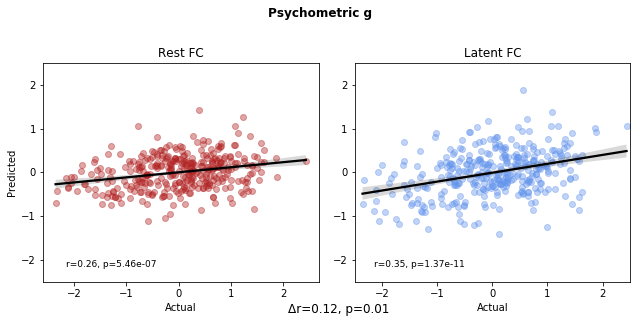

In [186]:
group = 'overall'

if subj_group_g == 'overall':
    eid_rd = 0.12
    eid_t = 2.327
    eid_p = 0.01
elif subj_group_g == 'exploratory':
    eid_rd = 0.30
    eid_t = 6.025
    eid_p = 0.001
elif subj_group_g == 'validation':
    eid_rd = 0.08
    eid_t = 1.209
    eid_p = 0.113

if group == 'overall':
    g_vals = np.squeeze(g_df.values)
    rest_pred_g_vals = np.squeeze(rest_loso_g.values)
    latent_pred_g_vals = np.squeeze(latent_loso_g.values)
if group == 'exploratory':
    g_vals = np.squeeze(g_df.loc[subjs_g_expl].values)
    rest_pred_g_vals = np.squeeze(rest_loso_g.loc[subjs_g_expl].values)
    latent_pred_g_vals = np.squeeze(latent_loso_g.loc[subjs_g_expl].values)
if group == 'validation':
    g_vals = np.squeeze(g_df.loc[subjs_g_val].values)
    rest_pred_g_vals = np.squeeze(rest_loso_g.loc[subjs_g_val].values)
    latent_pred_g_vals = np.squeeze(latent_loso_g.loc[subjs_g_val].values)    

    
plt.figure(figsize=(9,4))
plt.suptitle('Psychometric g', fontsize=12, fontweight='bold', y=1.1)

plt.subplot(121)
r, p = pearsonr(g_vals, rest_pred_g_vals)
#plt.scatter(g_vals, rest_pred_g_vals, s=25, alpha=0.4, color='indianred')
plt.title('Rest FC', fontsize=12)
plt.xlabel('Actual', fontsize=10)
plt.ylabel('Predicted', fontsize=10)
plt.text(-2.15,-2.15, 'r=%.2f, p=%.2e' % (r, p), fontsize=9)
#plt.xlim(-2.5,2.5)
plt.ylim(-2.5,2.5)
sns.regplot(g_vals, rest_pred_g_vals, scatter_kws={'color': 'firebrick', 'alpha': .4}, line_kws={'color': 'k'})

plt.subplot(122)
r, p = pearsonr(g_vals, latent_pred_g_vals)

plt.title('Latent FC', fontsize=12)
plt.xlabel('Actual', fontsize=10)
#plt.ylabel('Predicted psychometric g', fontsize=12)
plt.text(-2.15,-2.15, 'r=%.2f, p=%.2e' % (r, p), fontsize=9)
plt.xlim(-2.5,2.5)
plt.ylim(-2.5,2.5)
sns.regplot(g_vals, latent_pred_g_vals, scatter_kws={'color': 'cornflowerblue', 'alpha': .4}, line_kws={'color': 'k'})

plt.tight_layout()
if subj_group_g == 'exploratory':
    plt.text(-4, -3.2, '\u0394r=%.2f, p=<%.3f' % (eid_rd, eid_p), fontsize=12);
elif subj_group_g == 'validation':
    plt.text(-3.8, -3.2, '\u0394r=%.2f, p=%.2f' % (eid_rd, eid_p), fontsize=12);
elif subj_group_g == 'overall':
    plt.text(-3.7, -3.2, '\u0394r=%.2f, p=%.2f' % (eid_rd, eid_p), fontsize=12);

plotname = '%s/predictg_restlatent_cross_sample_%s' % (figdir, group)
plt.savefig('%s.pdf' % plotname)
plt.savefig('%s.png' % plotname, dpi=300, transparent=True)